# Cleaning Data

At this stage, it is important to clean the 100x100data. 

Several issues were highlighted throughout the process.

### # of Finishers
As part of the analysis, DUV and ITRA finishers time were downloaded to verify runner's status and, if lucky, finishing time. 

When comparing the scraped 100x100 data to DUV and ITRA, it came to light that sometimes, runners are marked as finished on 100x100trail, although they did not get a finishers status on ITRA or DUV. THis required cleaning. 

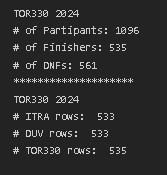

Furthermore, sometimes runners were given a status of not finished. THis was easily fixed by checking their timestamp at finish line (Courmayer). However, in that case, it was made sure that there was a timestamp for them between road Stages

### Life bases / Refugees

Several cleaning methods were deployed to clean this column. There were 'RITIRIO' in some values, so this needed to be stripped and kept in a different column 

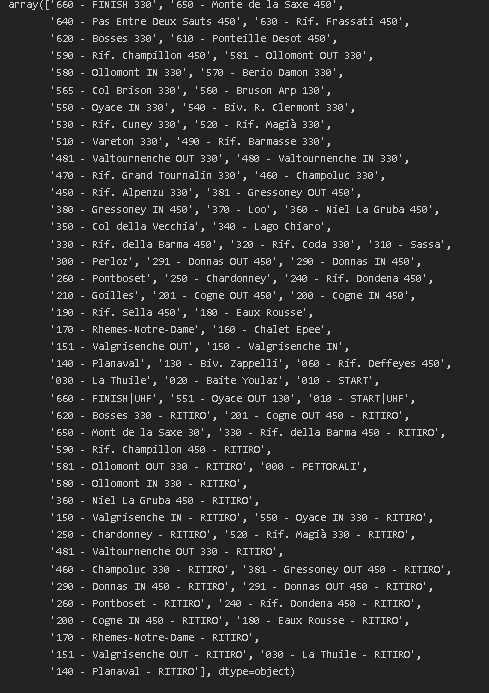


### 'Time' column
'Time' Column is one the most important columns in this process and needs to be meticulously cleaned for errors and inconsitencies!

The timesstamps had '+02:00' which was not necessary once inspected. 
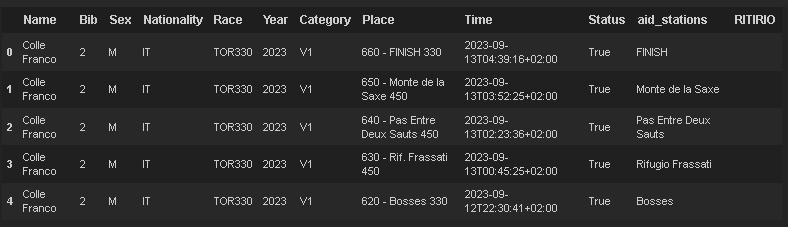


### Starting Time
Starting Times were also inaccurate. The starting time was set random times (who knows why?) but the times were changed to reflect wave start times!
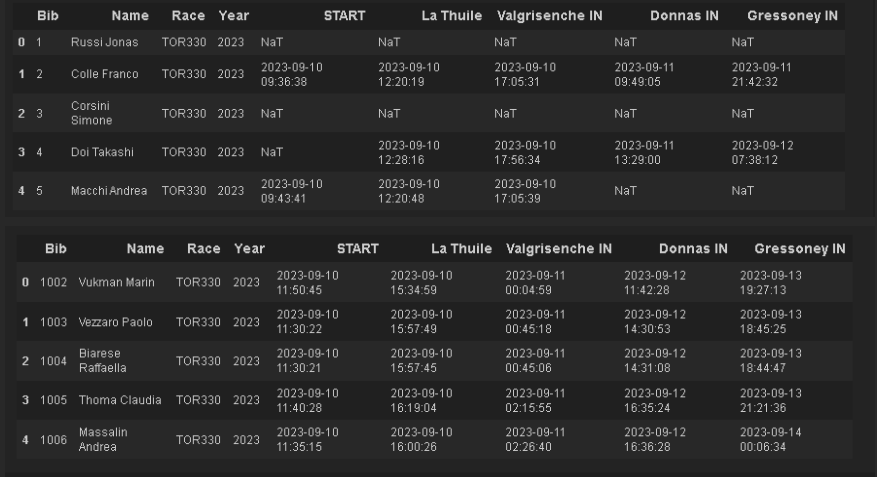

To deal with the Start Time, issue, DUV data was used to detect the start date for each year

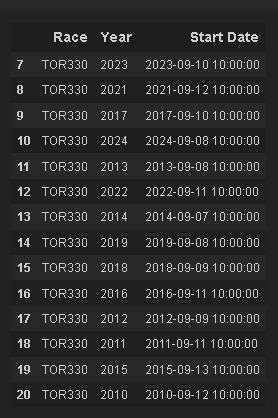

In [1]:
import re
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns

# Start the timer
start_time = time.time()

In [2]:
# # Set pandas options to display all columns and rows
# pd.set_option('display.max_columns', None)  # Show all columns
# pd.set_option('display.max_rows', None)     # Show all rows

In [3]:
def saving_tableau_df(df, name):
    # Specify the file path
    file_path = f'{race} Data/5. Clean Data for Data Visualisation/{race}_{name}.xlsx'

    # Check if the file exists
    if os.path.exists(file_path):
        # Read the existing file into a DataFrame
        existing_data = pd.read_excel(file_path)

        # Reset the index to ensure no duplicate indices
        existing_data.reset_index(drop=True, inplace=True)
        df.reset_index(drop=True, inplace=True)
        
        for num_column in ['Bib', 'Year']:
            df[num_column] = df[num_column].astype('int')
            df[num_column] = df[num_column].astype('str')

        # Find rows in TOR330_dem that are not in the existing_data
        new_rows = df[~df.apply(tuple, axis=1).isin(existing_data.apply(tuple, axis=1))]

        if not new_rows.empty:
            # Concatenate the new rows to the existing data, resetting the index afterward
            updated_data = pd.concat([existing_data, new_rows], ignore_index=True)

            # Save the updated data back to the file
            updated_data.to_excel(file_path, index=False)
            print("New rows added to the file.")
        else:
            print("No new rows to add. File remains unchanged.")
    else:
        # If the file doesn't exist, save the DataFrame as a new file
        df.to_excel(file_path, index=False)
        print(f"File created at {file_path}.")


In [4]:
def create_lifebase_checkpoint_and_aid_station_sub_df(df, column_list, column, dem_list, category_order):
    sub_df= df[column_list]

    # Pivot the data using melt
    melt_sub_df = sub_df.melt(id_vars= dem_list, 
                         var_name=column, 
                         value_name=f"Timestamp")

    # Set 'Finish Category' as a categorical column with the defined order
    melt_sub_df[column] = pd.Categorical(
        melt_sub_df[column],
        categories = category_order,
        ordered=True
    )
    
    melt_sub_df[column] = melt_sub_df[column].str.replace('Start Date','Start')

    return melt_sub_df

In [5]:
def fixing_negative_duration(df):
    # to replace all negative values with Nan
    df.loc[df['Duration'] < pd.to_timedelta('00:00:00'), 'Timestamp'] = pd.NaT
    df.loc[df['Duration'] < pd.to_timedelta('00:00:00'), 'Running Total Duration'] = np.nan
    df.loc[df['Duration'] < pd.to_timedelta('00:00:00'), 'Running Total Duration_seconds'] = np.nan
    df.loc[df['Duration'] < pd.to_timedelta('00:00:00'), 'Duration_seconds'] = np.nan
    df.loc[df['Duration'] < pd.to_timedelta('00:00:00'), 'Duration'] = np.nan


In [6]:
def calculating_banked_time(df, df_cut_offs_df, column):
    
    # Merge the datsets back together
    df = df.merge(
        df_cut_offs_df[[column, f'Running Total {column} Duration']], 
        right_on=[column],
        left_on=[column],
        how='left'
    )

    df['Banking Time'] = df[f'Running Total {column} Duration'] - df['Running Total Duration']
    df[f'Banking Time_seconds'] = pd.to_timedelta( df[f"Banking Time"], errors='coerce').dt.total_seconds()
    print(df[['Bib', column,\
              f'Running Total {column} Duration',\
              'Running Total Duration', 'Banking Time']][df['Bib'] == '1440'].head(5).transpose())
    return df


In [7]:
lifebase_category_order = [
    'Start',
    'Valgrisenche IN','Valgrisenche OUT',
    'Cogne IN',  'Cogne OUT',
    'Donnas IN', 'Donnas OUT', 
    'Gressoney IN','Gressoney OUT',
    'Valtournenche IN','Valtournenche OUT', 
    'Ollomont IN','Ollomont OUT',
    'FINISH']


In [8]:
aid_station_category_order = [
    'Start Date', 'Baite Youlaz', 'La Thuile', 'Rifugio Deffeyes',
       'Planaval', 'Valgrisenche IN', 'Valgrisenche OUT', 'Chalet Epee',
       'Rhemes-Notre-Dame', 'Eaux Rousse', 'Rifugio Sella', 'Cogne IN',
       'Cogne OUT', 'Goilles', 'Rifugio Dondena', 'Chardonney', 'Pontboset',
       'Donnas IN', 'Donnas OUT', 'Perloz', 'Sassa', 'Rifugio Coda',
       'Rifugio della Barma', 'Lago Chiaro', 'Col della Vecchia',
       'Niel La Gruba', 'Loo', 'Gressoney IN', 'Gressoney OUT',
       'Rifugio Alpenzu', 'Champoluc', 'Rifugio Grand Tournalin',
       'Valtournenche IN', 'Valtournenche OUT', 'Rifugio Barmasse', 'Vareton',
       'Rifugio Magià', 'Rifugio Cuney', 'Bivacco R. Clermont', 'Oyace',
       'Bruson Arp', 'Ollomont IN', 'Ollomont OUT', 'Rifugio Champillon',
       'Ponteille Desot', 'Bosses', 'Rifugio Frassati', 'Pas Entre Deux Sauts',
       'Monte de la Saxe', 'FINISH']


## Looping through scraped data from 100X100trail

In [9]:
races = ['TOR330']
years = [ 
#     '2021',
#         '2022',
#          '2023', 
    '2024'
        ]

TORX_df = {}

for race in races:
    for year in years:
        df = pd.read_excel(f'{race} Data/1. 100x100trail/{race}_{year}.xlsx',
                                 dtype={'Start Date': 'string',
                                        'Year': 'string'})
        print(f'{race}_{year} {df.shape}')
        # Store the DataFrame in the dictionary with a key like 'TOR330_2021'
        TORX_df[f'{race}_{year}'] = df
    print('*'*50)

TOR330_2024 (39181, 10)
**************************************************


In [10]:
TORX_df_concat = pd.concat(TORX_df)

In [11]:
TOR330 = TORX_df_concat[TORX_df_concat['Year'] == year]
TOR330.head()

Name  Bib Sex Nationality    Race  Year Category  \
TOR330_2024 0  D Haene Francois   10   M          FR  TOR330  2024      SEN   
            1  D Haene Francois   10   M          FR  TOR330  2024      SEN   
            2  D Haene Francois   10   M          FR  TOR330  2024      SEN   
            3  D Haene Francois   10   M          FR  TOR330  2024      SEN   
            4  D Haene Francois   10   M          FR  TOR330  2024      SEN   

                                        Place                       Time  \
TOR330_2024 0                660 - FINISH 330  2024-09-11T07:08:32+02:00   
            1      650 - Monte de la Saxe 450  2024-09-11T06:25:42+02:00   
            2  640 - Pas Entre Deux Sauts 450  2024-09-11T05:01:52+02:00   
            3         630 - Rif. Frassati 450  2024-09-11T03:24:39+02:00   
            4                620 - Bosses 330  2024-09-11T00:52:13+02:00   

               Status  
TOR330_2024 0    True  
            1    True  
            2    True  
            3    True  
            4    True

In [12]:
def counting_finish_DNF_dataset(df):
    for year in years :
        for race in races:

            if len(df['Name'][(df['Year'] == year) & (df['Race'] == race)].unique()) != 0:
                print(race , year)
                ## The data is currently stacked so every checkpoint has a unique row
                # using the unique function to count unique participants in the data
                print('# of Partipants:', len(df['Name'][(df['Year'] == year) &
                                                        (df['Race'] == race)].unique()))
                
                
                
                # Finishers
                print('# of Finishers:', len(df['Name'][(df['Year'] == year) &
                                                        (df['Race'] == race) &
                                                        (df['Status'] ==  True)].unique()))
                # DNFs
                print('# of DNFs:', len(df['Name'][(df['Year'] == year) &
                                                        (df['Race'] == race) &
                                                        (df['Status'] ==  False)].unique()))
                print('*'*20)
            else:
                pass
            
counting_finish_DNF_dataset(TOR330)

TOR330 2024
# of Partipants: 1096
# of Finishers: 535
# of DNFs: 561
********************


In [13]:
def counting_groupby_dataset(df, column):
    for year in years :
        for race in races:
            
            df = df[['Name', 'Status', 'Year', 'Race']].drop_duplicates()

            if len(df['Name'][(df['Year'] == year) & (df['Race'] == race)].unique()) != 0:
                print(race , year)
                ## The data is currently stacked so every checkpoint has a unique row
                # using the unique function to count unique participants in the data
                print('# of Partipants:', len(df['Name'][(df['Year'] == year) &
                                                        (df['Race'] == race)].unique()), '\n')
                
                print(df.groupby([column])[column].count())
                print('*'*20)
            else:
                pass
counting_groupby_dataset(df,  'Status')

TOR330 2024
# of Partipants: 1096 

Status
False    561
True     535
Name: Status, dtype: int64
********************


### DUV and ITRA data


#### # of Finishers
As part of the analysis, DUV and ITRA finishers time were downloaded to verify runner's status and, if lucky, finishing time. 

When comparing the scraped 100x100 data to DUV and ITRA, it came to light that sometimes, runners are marked as finished on 100x100trail, although they did not get a finishers status on ITRA or DUV. THis required cleaning. 

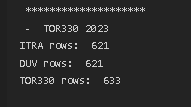


In [14]:
TORX_duv_df = pd.read_excel(f'{race} data/5. Clean Data for Data Visualisation/{race}_duv.xlsx',
                                     dtype={'Year': 'string'})

TORX_itra_no_DNF = pd.read_excel(f'{race} Data/5. Clean Data for Data Visualisation/{race}_itra_no_DNF.xlsx',
                                     dtype={'Year': 'string'})

In [15]:
def find_out_the_rows_difference_between_datasets(df):
    for year in years :
        for race in races:
            if len(df['Name'][(df['Year'] == year)]) != 0:

                print(race, year)
                print('# ITRA rows: ', TORX_itra_no_DNF[(TORX_itra_no_DNF['Year'] == year) &
                                  (TORX_itra_no_DNF['Race'] == race)].shape[0])
                print('# DUV rows: ',TORX_duv_df[(TORX_duv_df['Year'] == year) &
                                  (TORX_duv_df['Race'] == race)].shape[0])

                print('# TOR330 rows: ', len(df['Name'][(df['Year'] == year) &
                                                 (df['Race'] == race) &
                                                 (df['Status'] == True)].unique()))
                print('\n', '*'*20)
                
                if year == '2022':
                    print(' - ','TOR330','2022')
                    print(TORX_itra_no_DNF[(TORX_itra_no_DNF['Race'] == 'TOR330') &
                          (TORX_itra_no_DNF['Year'] == '2022')].groupby(['Status'])['Status'].count())
                    print('\n', '*'*20)
            else: 
                pass

In [16]:
counting_finish_DNF_dataset(TOR330)
find_out_the_rows_difference_between_datasets(TOR330)
counting_groupby_dataset(TOR330,  'Status')

TOR330 2024
# of Partipants: 1096
# of Finishers: 535
# of DNFs: 561
********************
TOR330 2024
# ITRA rows:  533
# DUV rows:  533
# TOR330 rows:  535

 ********************
TOR330 2024
# of Partipants: 1096 

Status
False    561
True     535
Name: Status, dtype: int64
********************


### Cleaning Place column

In [17]:
TOR330['Place'].unique()

array(['660 - FINISH 330', '650 - Monte de la Saxe 450',
       '640 - Pas Entre Deux Sauts 450', '630 - Rif. Frassati 450',
       '620 - Bosses 330', '610 - Ponteille Desot 450',
       '590 - Rif. Champillon 450', '581 - Ollomont OUT 330',
       '580 - Ollomont IN 330', '570 - Berio Damon 330',
       '565 - Col Brison 330', '560 - Bruson Arp 130',
       '550 - Oyace IN 330', '540 - Biv. R. Clermont 330',
       '530 - Rif. Cuney 330', '520 - Rif. Magià 330',
       '510 - Vareton 330', '490 - Rif. Barmasse 330',
       '481 - Valtournenche OUT 330', '480 - Valtournenche IN 330',
       '470 - Rif. Grand Tournalin 330', '460 - Champoluc 330',
       '450 - Rif. Alpenzu 330', '381 - Gressoney OUT 450',
       '380 - Gressoney IN 450', '370 - Loo', '360 - Niel La Gruba 450',
       '350 - Col della Vecchia', '340 - Lago Chiaro',
       '330 - Rif. della Barma 450', '320 - Rif. Coda 330', '310 - Sassa',
       '300 - Perloz', '291 - Donnas OUT 450', '290 - Donnas IN 450',
       '260

In [18]:
# 030 - La Thuile - RITIRO
TOR330['aid_stations'] = TOR330['Place'].str.split(r'^\d+ - ').str.get(-1)
TOR330['aid_stations'] = TOR330['aid_stations'].str.replace('Rif. della Balm 450a','Rif. della Barma')
TOR330['aid_stations'] = TOR330['aid_stations'].str.replace(r'\d+', '', regex=True)
TOR330['aid_stations'] = TOR330['aid_stations'].str.split('|').str.get(0)
TOR330['aid_stations'] = TOR330['aid_stations'].str.replace('Rif.', 'Rifugio')
TOR330['aid_stations'] = TOR330['aid_stations'].str.replace('Biv.','Bivacco')
TOR330['aid_stations'] = TOR330['aid_stations'].str.replace('Niel - ','Niel ')
TOR330['aid_stations'] = TOR330['aid_stations'].str.replace('Oyace IN','Oyace')
TOR330['aid_stations'] = TOR330['aid_stations'].str.replace('  ',' ')
TOR330['aid_stations'] = TOR330['aid_stations'].str.replace('Mont de la Saxe','Monte de la Saxe')
TOR330['aid_stations'] = TOR330['aid_stations'].str.replace('Rifugio della Barmasse', 'Rifugio Barmasse')
TOR330['aid_stations'] = TOR330['aid_stations'].str.replace('Promoud','Bivacco Zappelli')
TOR330['aid_stations'] = TOR330['aid_stations'].str.replace('FINISH - UHF','FINISH')
TOR330['aid_stations'] = TOR330['aid_stations'].str.replace('START - MANUAL','START')
TOR330['aid_stations'] = TOR330['aid_stations'].str.strip()
TOR330['RITIRIO'] = np.where(
    TOR330['aid_stations'].str.contains('RITIRO', na=False), 
    TOR330['aid_stations'],  '')
# TOR330['RITIRIO] =TOR330['RITIRIO].str.replace('- RITIRO', '')
TOR330['aid_stations'] = TOR330['aid_stations'].str.split(' - RITIRO').str.get(0)

TOR330 = TOR330[~(TOR330['aid_stations'] == '') ]
print(', '.join(list(TOR330['aid_stations'].unique())))


C:\Users\Karina\AppData\Local\Temp\ipykernel_21692\502743564.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  TOR330['aid_stations'] = TOR330['aid_stations'].str.replace('Rif. della Balm 450a','Rif. della Barma')
C:\Users\Karina\AppData\Local\Temp\ipykernel_21692\502743564.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  TOR330['aid_stations'] = TOR330['aid_stations'].str.replace('Rif.', 'Rifugio')
C:\Users\Karina\AppData\Local\Temp\ipykernel_21692\502743564.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  TOR330['aid_stations'] = TOR330['aid_stations'].str.replace('Biv.','Bivacco')


FINISH, Monte de la Saxe, Pas Entre Deux Sauts, Rifugio Frassati, Bosses, Ponteille Desot, Rifugio Champillon, Ollomont OUT, Ollomont IN, Berio Damon, Col Brison, Bruson Arp, Oyace, Bivacco R. Clermont, Rifugio Cuney, Rifugio Magià, Vareton, Rifugio Barmasse, Valtournenche OUT, Valtournenche IN, Rifugio Grand Tournalin, Champoluc, Rifugio Alpenzu, Gressoney OUT, Gressoney IN, Loo, Niel La Gruba, Col della Vecchia, Lago Chiaro, Rifugio della Barma, Rifugio Coda, Sassa, Perloz, Donnas OUT, Donnas IN, Pontboset, Chardonney, Rifugio Dondena, Goilles, Cogne OUT, Cogne IN, Rifugio Sella, Eaux Rousse, Rhemes-Notre-Dame, Chalet Epee, Valgrisenche OUT, Valgrisenche IN, Planaval, Bivacco Zappelli, Rifugio Deffeyes, La Thuile, Baite Youlaz, START, Oyace OUT, PETTORALI


In [19]:
# copy the column to make a new column
for i in list(TOR330['RITIRIO'].unique()):
    print(i)


Bosses - RITIRO
Cogne OUT - RITIRO
Rifugio della Barma - RITIRO
Rifugio Champillon - RITIRO
Ollomont OUT - RITIRO
Ollomont IN - RITIRO
Niel La Gruba - RITIRO
Valgrisenche IN - RITIRO
Oyace - RITIRO
Chardonney - RITIRO
Rifugio Magià - RITIRO
Valtournenche OUT - RITIRO
Champoluc - RITIRO
Gressoney OUT - RITIRO
Donnas IN - RITIRO
Donnas OUT - RITIRO
Pontboset - RITIRO
Rifugio Dondena - RITIRO
Cogne IN - RITIRO
Eaux Rousse - RITIRO
Rhemes-Notre-Dame - RITIRO
Valgrisenche OUT - RITIRO
La Thuile - RITIRO
Planaval - RITIRO


In [20]:
# copy the column to make a new column
for i in list(TOR330['aid_stations'].unique()):
    print(i)

FINISH
Monte de la Saxe
Pas Entre Deux Sauts
Rifugio Frassati
Bosses
Ponteille Desot
Rifugio Champillon
Ollomont OUT
Ollomont IN
Berio Damon
Col Brison
Bruson Arp
Oyace
Bivacco R. Clermont
Rifugio Cuney
Rifugio Magià
Vareton
Rifugio Barmasse
Valtournenche OUT
Valtournenche IN
Rifugio Grand Tournalin
Champoluc
Rifugio Alpenzu
Gressoney OUT
Gressoney IN
Loo
Niel La Gruba
Col della Vecchia
Lago Chiaro
Rifugio della Barma
Rifugio Coda
Sassa
Perloz
Donnas OUT
Donnas IN
Pontboset
Chardonney
Rifugio Dondena
Goilles
Cogne OUT
Cogne IN
Rifugio Sella
Eaux Rousse
Rhemes-Notre-Dame
Chalet Epee
Valgrisenche OUT
Valgrisenche IN
Planaval
Bivacco Zappelli
Rifugio Deffeyes
La Thuile
Baite Youlaz
START
Oyace OUT
PETTORALI


### Cleaning Time column

Column '2024-09-11T07:08:32+02:00' needs to be fixed into '2024-09-11 07:08:32' and turned into the datetime

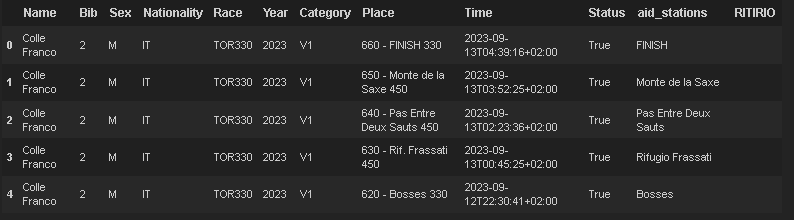

In [21]:
# 2024-09-11T07:08:32+02:00

# Split the 'Time' column to remove the timezone offset
TOR330['new_Time'] = TOR330['Time'].str.split('+').str[0]

# Convert the cleaned time string to a datetime object
TOR330['new_Time'] = pd.to_datetime(TOR330['new_Time'])

# # Add the 2-hour offset using timedelta
# # NO NEED!!!
# TOR330['new_Time'] = TOR330['new_Time'] + pd.to_timedelta('02:00:00')

# Preview the DataFrame
TOR330.head()

Name  Bib Sex Nationality    Race  Year Category  \
TOR330_2024 0  D Haene Francois   10   M          FR  TOR330  2024      SEN   
            1  D Haene Francois   10   M          FR  TOR330  2024      SEN   
            2  D Haene Francois   10   M          FR  TOR330  2024      SEN   
            3  D Haene Francois   10   M          FR  TOR330  2024      SEN   
            4  D Haene Francois   10   M          FR  TOR330  2024      SEN   

                                        Place                       Time  \
TOR330_2024 0                660 - FINISH 330  2024-09-11T07:08:32+02:00   
            1      650 - Monte de la Saxe 450  2024-09-11T06:25:42+02:00   
            2  640 - Pas Entre Deux Sauts 450  2024-09-11T05:01:52+02:00   
            3         630 - Rif. Frassati 450  2024-09-11T03:24:39+02:00   
            4                620 - Bosses 330  2024-09-11T00:52:13+02:00   

               Status          aid_stations RITIRIO            new_Time  
TOR330_2024 0    True                FINISH         2024-09-11 07:08:32  
            1    True      Monte de la Saxe         2024-09-11 06:25:42  
            2    True  Pas Entre Deux Sauts         2024-09-11 05:01:52  
            3    True      Rifugio Frassati         2024-09-11 03:24:39  
            4    True                Bosses         2024-09-11 00:52:13

In [22]:
for i in TOR330.aid_stations.unique():
    print(i)

FINISH
Monte de la Saxe
Pas Entre Deux Sauts
Rifugio Frassati
Bosses
Ponteille Desot
Rifugio Champillon
Ollomont OUT
Ollomont IN
Berio Damon
Col Brison
Bruson Arp
Oyace
Bivacco R. Clermont
Rifugio Cuney
Rifugio Magià
Vareton
Rifugio Barmasse
Valtournenche OUT
Valtournenche IN
Rifugio Grand Tournalin
Champoluc
Rifugio Alpenzu
Gressoney OUT
Gressoney IN
Loo
Niel La Gruba
Col della Vecchia
Lago Chiaro
Rifugio della Barma
Rifugio Coda
Sassa
Perloz
Donnas OUT
Donnas IN
Pontboset
Chardonney
Rifugio Dondena
Goilles
Cogne OUT
Cogne IN
Rifugio Sella
Eaux Rousse
Rhemes-Notre-Dame
Chalet Epee
Valgrisenche OUT
Valgrisenche IN
Planaval
Bivacco Zappelli
Rifugio Deffeyes
La Thuile
Baite Youlaz
START
Oyace OUT
PETTORALI


### PIVOTING the Dataset

In [23]:
# Pivot the data so that each participant has its own column
pivoted_TOR330 = TOR330.pivot_table(
    index=['Name','Bib', 'Sex', 
           'Nationality', 'Category', 'Race','Year', 'Status' , #'RITIRIO'
          ],
    columns='aid_stations',  
    values='new_Time',
    aggfunc='first'  # Ensures only the first match is kept in case of duplicates
).reset_index()


# pivoted_TOR330 = pivoted_TOR330.sort_values(by = 'Bib', ascending = True)
pivoted_TOR330.head()

aid_stations,Name,Bib,Sex,Nationality,Category,Race,Year,Status,Baite Youlaz,Berio Damon,...,Rifugio Magià,Rifugio Sella,Rifugio della Barma,START,Sassa,Valgrisenche IN,Valgrisenche OUT,Valtournenche IN,Valtournenche OUT,Vareton
0,Abe Hiroshi,374,M,JP,V1,TOR330,2024,False,2024-09-08 13:03:31,NaT,...,NaT,2024-09-09 22:34:45,2024-09-11 10:57:38,2024-09-08 09:24:25,2024-09-11 04:02:41,2024-09-09 00:43:19,2024-09-09 04:15:35,NaT,NaT,NaT
1,Acerbi Luca,1275,M,IT,V3,TOR330,2024,False,2024-09-08 15:17:04,NaT,...,NaT,NaT,NaT,2024-09-08 11:37:12,NaT,2024-09-09 04:40:58,NaT,NaT,NaT,NaT
2,Adamczyk Guillaume,1376,M,BE,V2,TOR330,2024,False,2024-09-08 15:52:36,NaT,...,NaT,NaT,NaT,2024-09-08 11:44:44,NaT,2024-09-09 06:50:49,2024-09-09 08:45:53,NaT,NaT,NaT
3,Ade Gregory,366,M,FR,V2,TOR330,2024,True,2024-09-08 13:08:04,2024-09-12 19:37:42,...,2024-09-12 08:42:21,2024-09-09 14:59:54,2024-09-10 21:03:34,2024-09-08 09:21:44,2024-09-10 15:27:20,2024-09-08 22:07:34,2024-09-09 00:04:03,2024-09-11 22:46:14,2024-09-12 02:16:37,2024-09-12 05:27:10
4,Adrian Scott,1266,M,GB,V2,TOR330,2024,False,2024-09-08 14:24:13,NaT,...,NaT,2024-09-09 15:59:38,2024-09-11 03:10:04,2024-09-08 11:19:38,2024-09-10 20:22:36,2024-09-08 23:55:07,2024-09-09 00:45:48,NaT,NaT,NaT


In [24]:
print(pivoted_TOR330.shape)
print(pivoted_TOR330.groupby(['Status'])['Status'].count())

(1095, 63)
Status
False    560
True     535
Name: Status, dtype: int64


In [25]:
pivoted_TOR330.columns

Index(['Name', 'Bib', 'Sex', 'Nationality', 'Category', 'Race', 'Year',
       'Status', 'Baite Youlaz', 'Berio Damon', 'Bivacco R. Clermont',
       'Bivacco Zappelli', 'Bosses', 'Bruson Arp', 'Chalet Epee', 'Champoluc',
       'Chardonney', 'Cogne IN', 'Cogne OUT', 'Col Brison',
       'Col della Vecchia', 'Donnas IN', 'Donnas OUT', 'Eaux Rousse', 'FINISH',
       'Goilles', 'Gressoney IN', 'Gressoney OUT', 'La Thuile', 'Lago Chiaro',
       'Loo', 'Monte de la Saxe', 'Niel La Gruba', 'Ollomont IN',
       'Ollomont OUT', 'Oyace', 'Oyace OUT', 'PETTORALI',
       'Pas Entre Deux Sauts', 'Perloz', 'Planaval', 'Pontboset',
       'Ponteille Desot', 'Rhemes-Notre-Dame', 'Rifugio Alpenzu',
       'Rifugio Barmasse', 'Rifugio Champillon', 'Rifugio Coda',
       'Rifugio Cuney', 'Rifugio Deffeyes', 'Rifugio Dondena',
       'Rifugio Frassati', 'Rifugio Grand Tournalin', 'Rifugio Magià',
       'Rifugio Sella', 'Rifugio della Barma', 'START', 'Sassa',
       'Valgrisenche IN', 'Valgrisenche

In [26]:
# reordering columns 
pivoted_TOR330 = pivoted_TOR330[[
'Name', 'Bib', 'Sex', 'Nationality', 'Year', 'Race','Category', 'Status', #'RITIRIO',  
'START', 'Baite Youlaz', 'La Thuile', 'Rifugio Deffeyes', 
    # 'Bivacco Zappelli', 'Col Brison', 'Berio Damon' # Dropping these because its not very useful anyway!
    'Planaval', 'Valgrisenche IN', 'Valgrisenche OUT', 'Chalet Epee', 'Rhemes-Notre-Dame',
    'Eaux Rousse', 'Rifugio Sella', 'Cogne IN', 'Cogne OUT', 'Goilles', 'Rifugio Dondena', 
    'Chardonney', 'Pontboset', 'Donnas IN', 'Donnas OUT', 'Perloz', 'Sassa', 'Rifugio Coda',
    'Rifugio della Barma', 'Lago Chiaro', 'Col della Vecchia', 'Niel La Gruba', 'Loo',
    'Gressoney IN', 'Gressoney OUT', 'Rifugio Alpenzu', 'Champoluc', 'Rifugio Grand Tournalin', 
    'Valtournenche IN', 'Valtournenche OUT', 'Rifugio Barmasse', 'Vareton',
    'Rifugio Magià', 'Rifugio Cuney', 'Bivacco R. Clermont', 
    'Oyace', 'Bruson Arp',   'Ollomont IN', 
    'Ollomont OUT', 'Rifugio Champillon', 'Ponteille Desot', 'Bosses', 'Rifugio Frassati', 
    'Pas Entre Deux Sauts', 'Monte de la Saxe', 'FINISH']]

pivoted_TOR330 = pivoted_TOR330.sort_values(by = 'Bib', ascending = True)
pivoted_TOR330.head()

aid_stations,Name,Bib,Sex,Nationality,Year,Race,Category,Status,START,Baite Youlaz,...,Bruson Arp,Ollomont IN,Ollomont OUT,Rifugio Champillon,Ponteille Desot,Bosses,Rifugio Frassati,Pas Entre Deux Sauts,Monte de la Saxe,FINISH
218,Colle Franco,1,M,IT,2024,TOR330,V1,False,2024-08-24 23:40:09,NaT,...,2024-09-11 20:22:22,NaT,NaT,NaT,NaT,NaT,NaT,2024-09-14 07:58:11,NaT,NaT
1015,Verjee Sabrina,2,F,GB,2024,TOR330,V1,True,2024-08-24 23:41:09,2024-09-08 12:00:15,...,2024-09-11 07:47:36,2024-09-11 09:36:42,2024-09-11 09:41:25,2024-09-11 11:39:19,2024-09-11 13:21:27,2024-09-11 14:51:36,2024-09-11 17:42:39,2024-09-11 19:33:31,2024-09-11 21:05:48,2024-09-11 22:03:21
829,Reynolds Galen,3,M,CA,2024,TOR330,V1,False,2024-09-08 09:00:00,2024-09-08 11:47:21,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
119,Borzani Lisa,4,F,IT,2024,TOR330,V1,True,2024-09-08 09:00:00,2024-09-08 11:56:21,...,2024-09-11 11:26:56,2024-09-11 13:35:51,2024-09-11 14:01:57,2024-09-11 15:47:55,2024-09-11 17:51:55,2024-09-11 19:37:12,2024-09-11 23:00:32,2024-09-12 02:16:14,2024-09-12 04:44:45,2024-09-12 06:09:34
353,Galeati Gianluca,5,M,IT,2024,TOR330,V1,False,2024-09-08 09:00:00,2024-09-08 11:47:54,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT


In [27]:
print(pivoted_TOR330.shape)
print(pivoted_TOR330.groupby(['Status'])['Status'].count())

(1095, 58)
Status
False    560
True     535
Name: Status, dtype: int64


### RITIRIO

Although every attempt was tried to include RITIRIO column in the dataset, it came to light that some people were twice marked retired. 

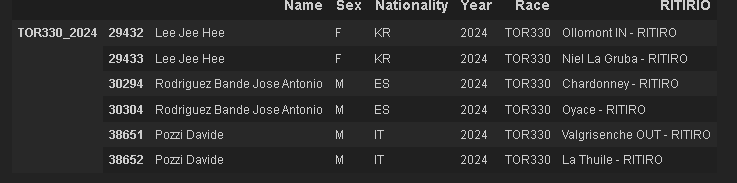

#### Solution
Do nothing. Dont reattach it to the pivoted dataset. It is useless anyway. Only 140 runners were marked as retired, very far from the DNF number.  

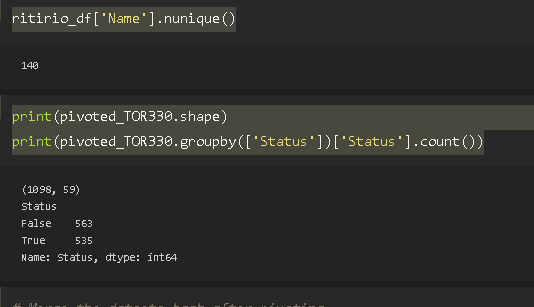

In [28]:
ritirio_df = TOR330[~(TOR330['RITIRIO'] == '')]
# ritirio_df = ritirio_df[['Bib', 'RITIRIO']]
ritirio_df.head()

Name   Bib Sex Nationality    Race  Year  \
TOR330_2024 8619   Hutchinson G Brian  1013   M          IE  TOR330  2024   
            9311         Cagna Andrea  1547   M          IT  TOR330  2024   
            28001       Park Kwangwon   150   M          KR  TOR330  2024   
            28262      Sotillo Antoni   232   M          ES  TOR330  2024   
            28556     Fioroni Massimo    62   M          IT  TOR330  2024   

                  Category                                Place  \
TOR330_2024 8619        V2            620 - Bosses 330 - RITIRO   
            9311        V1         201 - Cogne OUT 450 - RITIRO   
            28001       V1  330 - Rif. della Barma 450 - RITIRO   
            28262       V1            620 - Bosses 330 - RITIRO   
            28556       V2         201 - Cogne OUT 450 - RITIRO   

                                        Time  Status         aid_stations  \
TOR330_2024 8619   2024-09-13T06:21:34+02:00    True               Bosses   
            9311   2024-09-10T06:52:37+02:00    True            Cogne OUT   
            28001  2024-09-11T16:25:26+02:00   False  Rifugio della Barma   
            28262  2024-09-12T11:52:27+02:00   False               Bosses   
            28556  2024-09-10T01:52:27+02:00   False            Cogne OUT   

                                        RITIRIO            new_Time  
TOR330_2024 8619                Bosses - RITIRO 2024-09-13 06:21:34  
            9311             Cogne OUT - RITIRO 2024-09-10 06:52:37  
            28001  Rifugio della Barma - RITIRO 2024-09-11 16:25:26  
            28262               Bosses - RITIRO 2024-09-12 11:52:27  
            28556            Cogne OUT - RITIRO 2024-09-10 01:52:27

In [29]:
# Get a list of duplicate names
duplicate_list = ritirio_df['Name'][ritirio_df['Name'].duplicated()].unique()

# Filter the DataFrame to only rows where 'Name' is in the duplicate list
duplicates_in_dataframe = ritirio_df[ritirio_df['Name'].isin(duplicate_list)]

# Display or process the result
duplicates_in_dataframe[['Name', 'Sex', 'Nationality', 'Year', 'Race', 'RITIRIO' ]]


Name Sex Nationality  Year    Race  \
TOR330_2024 29432                   Lee Jee Hee   F          KR  2024  TOR330   
            29433                   Lee Jee Hee   F          KR  2024  TOR330   
            30294  Rodriguez Bande Jose Antonio   M          ES  2024  TOR330   
            30304  Rodriguez Bande Jose Antonio   M          ES  2024  TOR330   
            38651                  Pozzi Davide   M          IT  2024  TOR330   
            38652                  Pozzi Davide   M          IT  2024  TOR330   

                                     RITIRIO  
TOR330_2024 29432       Ollomont IN - RITIRO  
            29433     Niel La Gruba - RITIRO  
            30294        Chardonney - RITIRO  
            30304             Oyace - RITIRO  
            38651  Valgrisenche OUT - RITIRO  
            38652         La Thuile - RITIRO

In [30]:
ritirio_df['Name'].nunique()

140

In [31]:
print(pivoted_TOR330.shape)
print(pivoted_TOR330.groupby(['Status'])['Status'].count())

(1095, 58)
Status
False    560
True     535
Name: Status, dtype: int64


In [32]:
# # Merge the datsets back after pivoting
# pivoted_TOR330 = pivoted_TOR330.merge(
#     ritirio_df[['Bib', 'RITIRIO']].drop_duplicates(),  # Ensure no duplicates in 'Bib' and 'RITIRIO'
#     on='Bib',
#     how='left'
# )

In [33]:
print(pivoted_TOR330.shape)
print(pivoted_TOR330.groupby(['Status'])['Status'].count())

(1095, 58)
Status
False    560
True     535
Name: Status, dtype: int64


### Dealing with Anomalies

Several anomalies were spotted with the finish times. 

Some runners had a timestamp at the finish line, yet failed to be scanned Ollomont IN or OUT or any other refugee or checkpoints on the last stage. 


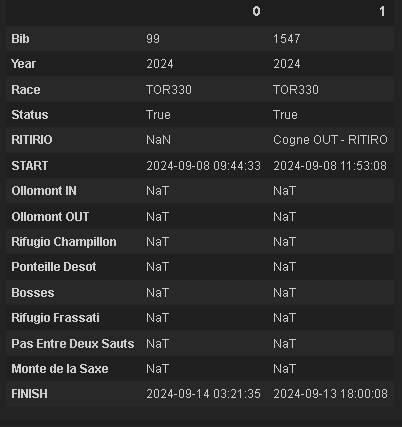

SOLUTION: change their status to FALSE and remove the timestamp

### 2023 Solution
9 participants were incorrectly labelled as finished!
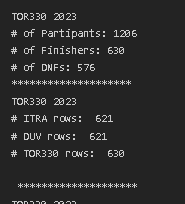

8 participants were identified as labelled finished and had a finish time but missed all stage 7 checkpoints
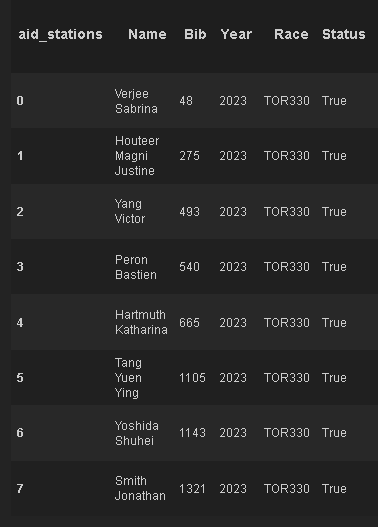



### 2024 Solution

In [34]:
# Looking for runners who have FINISHED< BUT have missing values for all last 3 checkpoints!
anomalies_df = pivoted_TOR330[(pivoted_TOR330['Status'] == True) &
               (pivoted_TOR330['Bosses'].isna()) &                
               (pivoted_TOR330['Rifugio Frassati'].isna()) & 
               (pivoted_TOR330['Pas Entre Deux Sauts'].isna()) &
               (pivoted_TOR330['Monte de la Saxe'].isna())]

anomalies_df[[ 'Name', 'Bib', 'Year', 'Race', 'Status',  'START',
    	'Ollomont IN',	'Ollomont OUT',
    'Rifugio Champillon', 'Ponteille Desot',
    'Bosses',	'Rifugio Frassati',	'Pas Entre Deux Sauts',	'Monte de la Saxe',
    'FINISH']].reset_index(drop = True)

### Conclusion: Easily visible that there are several other places that have missing values 

aid_stations,Name,Bib,Year,Race,Status,START,Ollomont IN,Ollomont OUT,Rifugio Champillon,Ponteille Desot,Bosses,Rifugio Frassati,Pas Entre Deux Sauts,Monte de la Saxe,FINISH
0,Martinez Raya Francisco Manuel,99,2024,TOR330,True,2024-09-08 09:44:33,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2024-09-14 03:21:35
1,Cagna Andrea,1547,2024,TOR330,True,2024-09-08 11:53:08,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2024-09-13 18:00:08


In [35]:
# EXECUTING SOLUTION
for name in anomalies_df['Name'].unique():  

    # Fixing the code with .loc[] for proper assignment
    pivoted_TOR330.loc[pivoted_TOR330['Name'] == name, 'FINISH'] = pd.NaT
    pivoted_TOR330.loc[pivoted_TOR330['Name'] == name, 'Status'] = False

In [36]:
# Looking for runners who have FINISHED< BUT dont haave a finish time!
anomalies_df = pivoted_TOR330[((pivoted_TOR330['Status'] == True) 
#                               &(pivoted_TOR330['FINISH'] == pd.NaT) 
                              )&
                              
                              (
                                  (pivoted_TOR330['Bosses'].isna()) |                
               (pivoted_TOR330['Rifugio Frassati'].isna()) | 
               (pivoted_TOR330['Pas Entre Deux Sauts'].isna()) |
               (pivoted_TOR330['Monte de la Saxe'].isna())
                              )]

anomalies_df[[ 'Name', 'Bib', 'Year', 'Race', 'Status',  'START',
    	'Ollomont IN',	'Ollomont OUT',
    'Rifugio Champillon', 'Ponteille Desot',
    'Bosses',	'Rifugio Frassati',	'Pas Entre Deux Sauts',	'Monte de la Saxe',
    'FINISH']]

### Conclusion: Easily visible that there are several other places that have missing values 

aid_stations,Name,Bib,Year,Race,Status,START,Ollomont IN,Ollomont OUT,Rifugio Champillon,Ponteille Desot,Bosses,Rifugio Frassati,Pas Entre Deux Sauts,Monte de la Saxe,FINISH
470,Jonkers Menno,29,2024,TOR330,True,2024-09-08 09:16:26,2024-09-13 04:00:33,2024-09-13 08:50:12,NaT,2024-09-13 13:24:49,2024-09-13 15:37:06,2024-09-13 19:33:56,NaT,2024-09-14 02:23:00,2024-09-14 04:18:36
127,Breuer Pierre,126,2024,TOR330,True,2024-09-08 09:19:01,2024-09-12 07:24:52,2024-09-12 09:17:44,2024-09-12 10:35:06,2024-09-12 12:02:23,2024-09-12 13:20:35,2024-09-12 15:39:19,NaT,2024-09-12 18:30:52,2024-09-12 19:16:27
453,Inglezou Asimina,164,2024,TOR330,True,2024-09-08 09:21:02,2024-09-12 18:08:44,2024-09-12 19:18:43,2024-09-12 21:28:32,2024-09-13 00:05:07,2024-09-13 02:13:34,2024-09-13 05:47:17,NaT,2024-09-13 13:01:49,2024-09-13 14:08:48
696,Moulis Pascal,177,2024,TOR330,True,2024-09-08 09:39:25,2024-09-12 16:28:29,2024-09-12 19:12:42,2024-09-12 21:45:39,2024-09-13 00:09:21,2024-09-13 02:37:56,2024-09-13 08:51:09,NaT,2024-09-13 12:29:19,2024-09-13 13:09:32
16,Allen Kaitlin,196,2024,TOR330,True,2024-09-08 09:27:00,2024-09-12 04:23:08,2024-09-12 05:11:44,2024-09-12 06:54:45,2024-09-12 08:54:31,2024-09-12 10:44:13,2024-09-12 13:31:14,NaT,2024-09-12 16:50:36,2024-09-12 17:47:42
29,Aquila Davide,425,2024,TOR330,True,2024-09-08 09:31:27,2024-09-13 13:17:06,2024-09-13 15:33:20,2024-09-13 17:29:27,2024-09-13 19:58:40,2024-09-13 22:42:28,2024-09-14 03:22:26,NaT,2024-09-14 12:17:00,2024-09-14 13:45:57
85,Bersoult Lucas,474,2024,TOR330,True,2024-09-08 09:43:15,2024-09-12 19:19:38,2024-09-12 22:40:30,2024-09-13 00:36:21,2024-09-13 02:35:44,2024-09-13 05:02:42,2024-09-13 08:30:30,NaT,2024-09-13 12:24:41,2024-09-13 13:07:13
206,Christophe Naudin,1113,2024,TOR330,True,2024-09-08 11:29:50,2024-09-13 16:31:36,2024-09-13 19:43:58,2024-09-13 22:09:24,2024-09-14 01:50:09,2024-09-14 05:09:54,2024-09-14 09:50:40,2024-09-14 13:04:23,NaT,2024-09-14 17:34:24
523,Kuusi Sami,1190,2024,TOR330,True,2024-09-08 11:46:27,2024-09-13 17:44:08,2024-09-13 19:59:15,2024-09-13 22:42:55,2024-09-14 02:23:40,2024-09-14 06:33:11,NaT,2024-09-14 12:10:28,2024-09-14 14:43:09,2024-09-14 16:17:44
45,Baggio Eros,1213,2024,TOR330,True,2024-09-08 11:36:59,2024-09-13 17:52:11,2024-09-13 20:29:24,2024-09-13 22:24:36,2024-09-14 01:55:28,2024-09-14 04:52:08,2024-09-14 08:37:00,2024-09-14 11:57:33,NaT,2024-09-14 15:58:50


In [37]:
counting_finish_DNF_dataset(pivoted_TOR330)
find_out_the_rows_difference_between_datasets(pivoted_TOR330)
counting_groupby_dataset(pivoted_TOR330,  'Status')

TOR330 2024
# of Partipants: 1095
# of Finishers: 533
# of DNFs: 562
********************
TOR330 2024
# ITRA rows:  533
# DUV rows:  533
# TOR330 rows:  533

 ********************
TOR330 2024
# of Partipants: 1095 

Status
False    562
True     533
Name: Status, dtype: int64
********************


### Start Line Issues

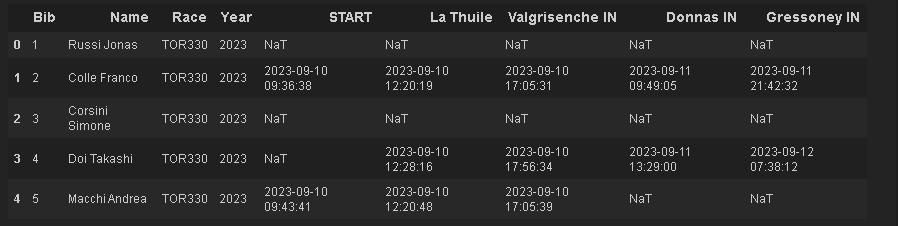

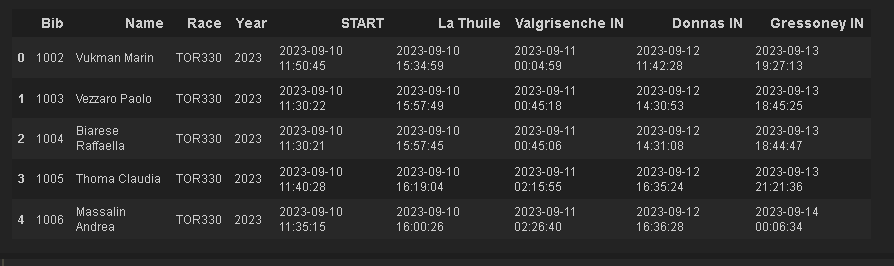

START times are all over the place and this is a MAJOR issue! 
It is important because if the start is not cleaned, it will affet the race finishing time and all the durations in between. 


#### SOLUTION
1) Made a new TIME column from DUV dates

2) added start times based on the wave (based on the bib)

##### Reading in TORX dates extracted from DUV

In [38]:
file = f'TORX DUV dates/TORX_duv_dates_df.xlsx'
dates_duv_df = pd.read_excel(file)

# Drop the intermediate columns if they're no longer needed
dates_duv_df = dates_duv_df.drop(columns=['Day_of_Week Start_Date'])    
dates_duv_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Race        26 non-null     object        
 1   Year        26 non-null     int64         
 2   Start Date  26 non-null     datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 752.0+ bytes


In [39]:
dates_duv_df[dates_duv_df['Race'] =='TOR330']

,Race,Year,Start Date
7,TOR330,2023,2023-09-10 10:00:00
8,TOR330,2021,2021-09-12 10:00:00
9,TOR330,2017,2017-09-10 10:00:00
10,TOR330,2024,2024-09-08 10:00:00
11,TOR330,2013,2013-09-08 10:00:00
12,TOR330,2022,2022-09-11 10:00:00
13,TOR330,2014,2014-09-07 10:00:00
14,TOR330,2019,2019-09-08 10:00:00
15,TOR330,2018,2018-09-09 10:00:00
16,TOR330,2016,2016-09-11 10:00:00


### Adding dates into TOR330

In [40]:
# making sure both columns are years!
pivoted_TOR330['Year'] = pivoted_TOR330['Year'].astype('str')
dates_duv_df['Year'] = dates_duv_df['Year'].astype('str')

# have I dropped any rows?
print(pivoted_TOR330.shape)

# Merging on two columns: 'Race' and 'Year'
pivoted_TOR330_dates = pd.merge(pivoted_TOR330, dates_duv_df, on=['Race', 'Year'], how='inner')

# have I dropped any rows?
print(pivoted_TOR330_dates.shape)



(1095, 58)
(1095, 59)


In [41]:
pivoted_TOR330_dates.columns

Index(['Name', 'Bib', 'Sex', 'Nationality', 'Year', 'Race', 'Category',
       'Status', 'START', 'Baite Youlaz', 'La Thuile', 'Rifugio Deffeyes',
       'Planaval', 'Valgrisenche IN', 'Valgrisenche OUT', 'Chalet Epee',
       'Rhemes-Notre-Dame', 'Eaux Rousse', 'Rifugio Sella', 'Cogne IN',
       'Cogne OUT', 'Goilles', 'Rifugio Dondena', 'Chardonney', 'Pontboset',
       'Donnas IN', 'Donnas OUT', 'Perloz', 'Sassa', 'Rifugio Coda',
       'Rifugio della Barma', 'Lago Chiaro', 'Col della Vecchia',
       'Niel La Gruba', 'Loo', 'Gressoney IN', 'Gressoney OUT',
       'Rifugio Alpenzu', 'Champoluc', 'Rifugio Grand Tournalin',
       'Valtournenche IN', 'Valtournenche OUT', 'Rifugio Barmasse', 'Vareton',
       'Rifugio Magià', 'Rifugio Cuney', 'Bivacco R. Clermont', 'Oyace',
       'Bruson Arp', 'Ollomont IN', 'Ollomont OUT', 'Rifugio Champillon',
       'Ponteille Desot', 'Bosses', 'Rifugio Frassati', 'Pas Entre Deux Sauts',
       'Monte de la Saxe', 'FINISH', 'Start Date'],
      dt

In [42]:

if year == '2021':
    pivoted_TOR330_dates['Wave'] = 'No Wave in 2021'
    
    
#     pivoted_TOR330_dates['Start Date']= pivoted_TOR330_dates['Start Date'] +pd.timedelta('02:00:00')

else:
    # Following the assumption that every bib prior to 1001 starts at 10:00:00
    pivoted_TOR330_dates['Start Date'] = np.where(
        pivoted_TOR330_dates['Bib'] < 1001, 
            pivoted_TOR330_dates['Start Date'], 
            pivoted_TOR330_dates['Start Date'] + pd.to_timedelta('02:00:00'))

    # Following the assumption that every bib from 1001 onwards starts at 12:00:00
    pivoted_TOR330_dates['Wave'] = np.where(
        pivoted_TOR330_dates['Bib'] <= 1001, 
            'Wave1', 
            'Wave2')
    


In [43]:
    pivoted_TOR330_dates[['Bib','Name', 'Race', 'Year',  
                'Start Date', 'La Thuile', 'Valgrisenche IN',
                'Donnas IN', 'Gressoney IN']][pivoted_TOR330_dates['Bib']< 1001].sort_values(by = 'Bib', ascending = True).reset_index(drop = True).head()

,Bib,Name,Race,Year,Start Date,La Thuile,Valgrisenche IN,Donnas IN,Gressoney IN
0,1,Colle Franco,TOR330,2024,2024-09-08 10:00:00,NaT,NaT,NaT,NaT
1,2,Verjee Sabrina,TOR330,2024,2024-09-08 10:00:00,2024-09-08 12:36:14,2024-09-08 18:06:48,2024-09-09 14:13:09,2024-09-10 08:06:44
2,3,Reynolds Galen,TOR330,2024,2024-09-08 10:00:00,2024-09-08 12:18:28,2024-09-08 17:12:09,NaT,NaT
3,4,Borzani Lisa,TOR330,2024,2024-09-08 10:00:00,2024-09-08 12:31:35,2024-09-08 18:06:56,2024-09-09 14:42:32,2024-09-10 11:32:56
4,5,Galeati Gianluca,TOR330,2024,2024-09-08 10:00:00,2024-09-08 12:20:05,2024-09-08 17:28:38,NaT,NaT


In [44]:
pivoted_TOR330_dates[['Bib','Name', 'Race', 'Year',  
                'Start Date', 'La Thuile', 'Valgrisenche IN',
                'Donnas IN', 'Gressoney IN']][pivoted_TOR330_dates['Bib']> 1001].sort_values(by = 'Bib', ascending = True).reset_index(drop = True).head()

,Bib,Name,Race,Year,Start Date,La Thuile,Valgrisenche IN,Donnas IN,Gressoney IN
0,1002,Rana Francesco,TOR330,2024,2024-09-08 12:00:00,2024-09-08 16:13:08,2024-09-09 02:11:42,2024-09-10 18:25:37,2024-09-11 22:24:03
1,1003,Del Re Domenico,TOR330,2024,2024-09-08 12:00:00,2024-09-08 16:09:10,2024-09-09 02:23:04,NaT,NaT
2,1004,Bellini Roberto,TOR330,2024,2024-09-08 12:00:00,2024-09-08 15:10:33,2024-09-08 22:44:21,2024-09-10 04:51:31,2024-09-11 08:49:09
3,1005,Spagarino Stefano,TOR330,2024,2024-09-08 12:00:00,2024-09-08 16:09:08,2024-09-09 02:11:38,2024-09-10 20:02:44,2024-09-12 00:27:15
4,1006,Pizzutti Riccardo,TOR330,2024,2024-09-08 12:00:00,NaT,2024-09-09 00:12:34,2024-09-10 11:35:15,2024-09-11 12:18:11


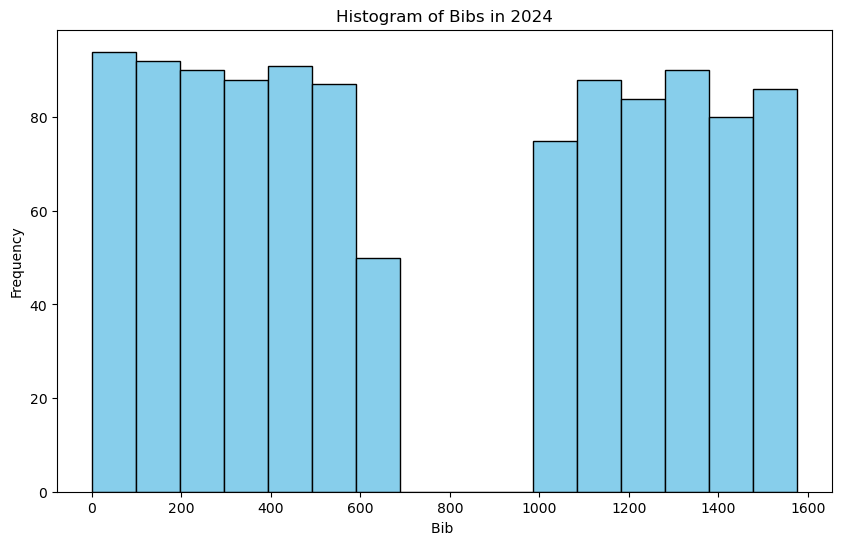

In [45]:
# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(pivoted_TOR330_dates['Bib'], bins=16, color='skyblue', edgecolor='black')
plt.title(f'Histogram of Bibs in {year}')
plt.xlabel('Bib ')
plt.ylabel('Frequency')
plt.show()

In [46]:
### WHich wave is more likely to finish? 
### Wave 1 seems to have way more finishers - they do have a higher ITRA score, meaning that they are more
### experienced and stronger than Wave 2..
pivoted_TOR330_dates.groupby(['Wave', 'Status'])['Status'].size()

Wave   Status
Wave1  False     227
       True      366
Wave2  False     335
       True      167
Name: Status, dtype: int64

### Calculating Duration - THE MOST IMPORTANT!

In [47]:
# Calculate Duration
pivoted_TOR330_dates['Duration'] = pivoted_TOR330_dates['FINISH'] - pivoted_TOR330_dates['Start Date'] 

# Sort the DataFrame by the 'Duration' column
pivoted_TOR330_dates = pivoted_TOR330_dates.sort_values(by='Duration')


Processing column: Duration
9    2 days 21:08:32
22   3 days 01:10:18
6    3 days 03:35:59
18   3 days 04:43:09
13   3 days 04:49:20
Name: Duration, dtype: timedelta64[ns]


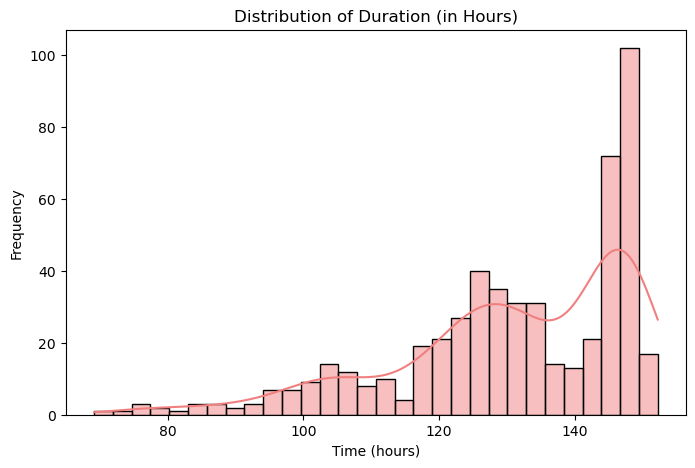

In [48]:
print(f"Processing column: Duration")
print(pivoted_TOR330_dates['Duration'].head())


pivoted_TOR330_dates['Duration']
# Convert to timedelta and get total hours (handling NaT)
pivoted_TOR330_dates['Duration_hours'] = pd.to_timedelta(
    pivoted_TOR330_dates['Duration'], errors='coerce'
).dt.total_seconds() / 3600  # Convert seconds to hours

# Drop NaN values for histogram visualization
data_to_plot = pivoted_TOR330_dates['Duration_hours'].dropna()

# Plot the histogram
plt.figure(figsize=(8, 5))
sns.histplot(data_to_plot, kde=True, bins=30, color="lightcoral")
plt.ticklabel_format(style='plain', axis='x')
plt.title(f"Distribution of Duration (in Hours)")
plt.xlabel("Time (hours)")
plt.ylabel("Frequency")
plt.show()


In [49]:
# Reorder the columns in the correct order
pivoted_TOR330_dates = pivoted_TOR330_dates[[
        'Name', 'Bib', 'Sex', 'Nationality', 'Year', 'Race', 
        'Category', 'Status','Wave',
         # MOVING DURATION CLOSER TO THE START SO I CAN SEE IT!
        'Duration'] +
        aid_station_category_order ]

### Checking accuracy of the Duration calculation

Because of issues with Start Date, it was thought that it would be a good idea to try and compare the DUV and ITRA duration time to establish accuracy of the calculation...

There are issues with the names, so some will be not be successfully merged.

In [50]:
# print(pivoted_TOR330_dates['Duration'][pivoted_TOR330_dates['Name'].str.contains('Jonina')])
# # print(TORX_duv_df['Performance'][TORX_duv_df['Name'].str.contains('Jonina')])
# # Finished in 144:46:43 hours and 

In [51]:
counting_finish_DNF_dataset(pivoted_TOR330)
find_out_the_rows_difference_between_datasets(pivoted_TOR330)
counting_groupby_dataset(pivoted_TOR330,  'Status')

TOR330 2024
# of Partipants: 1095
# of Finishers: 533
# of DNFs: 562
********************
TOR330 2024
# ITRA rows:  533
# DUV rows:  533
# TOR330 rows:  533

 ********************
TOR330 2024
# of Partipants: 1095 

Status
False    562
True     533
Name: Status, dtype: int64
********************


## extracting DNF and FInisher's for more cleaning!

In [52]:
pivoted_TOR330_dates_noDNF = pivoted_TOR330_dates[
                        # extracting runners whose status is True (Finished)
                        (pivoted_TOR330_dates['Status'] == True) &
                    ~(pivoted_TOR330_dates['FINISH'].isna())].reset_index()


In [53]:
pivoted_TOR330_dates_DNF = pivoted_TOR330_dates[
                    # selecting all rows that DNFed
                    (pivoted_TOR330_dates['Status'] == False) & # AND
                    # selecting all rows where FINISH does not have a time
                    (pivoted_TOR330_dates['FINISH'].isna())]

In [54]:
print(pivoted_TOR330_dates_noDNF.shape)
print(pivoted_TOR330_dates_DNF.shape)
print('MUST ADD UP TO:')
print(pivoted_TOR330_dates.shape)

(533, 61)
(562, 60)
MUST ADD UP TO:
(1095, 60)


### FINISHER'S Missing Timestamps
From time to time, timestamps are missing, even for finishers. Here is the missing values count for all finishers. 

THis is could be for several issues:
1) Participant's Fatigue - they forget to ask to be scanned

2) Volunteer's Fatigue - they forget to scan participants /  they thought they had already scanned the runer

3) Technology Failure - something goes wrong... ?
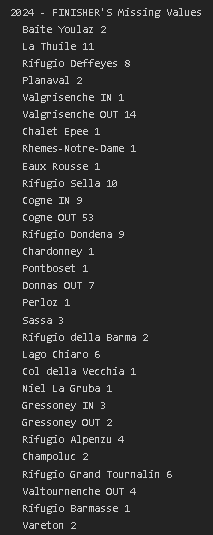

This is just a screenshot, more can be seen below!

### DNFs 

In [55]:
#### What missing values are there? 
### Some missing value is okay due to the fact that they DNFed so they wont have a timestamp
pivoted_TOR330_dates_DNF.isna().sum()

Name                         0
Bib                          0
Sex                          0
Nationality                  0
Year                         0
Race                         0
Category                     0
Status                       0
Wave                         0
Duration                   562
Start Date                   0
Baite Youlaz                12
La Thuile                   21
Rifugio Deffeyes            30
Planaval                    37
Valgrisenche IN             59
Valgrisenche OUT            99
Chalet Epee                100
Rhemes-Notre-Dame          115
Eaux Rousse                157
Rifugio Sella              232
Cogne IN                   248
Cogne OUT                  261
Goilles                    278
Rifugio Dondena            288
Chardonney                 283
Pontboset                  290
Donnas IN                  291
Donnas OUT                 305
Perloz                     311
Sassa                      310
Rifugio Coda               315
Rifugio 

# ALL Data in RAW

In [56]:

aid_station_dem_list = [ 'Year', 'Race', 'Name', 'Bib', 'Sex', 'Nationality',  'Category',
       'Status',  'Wave', 'Duration' ]

aid_station_column_list =  aid_station_dem_list + aid_station_category_order

pivoted_TOR330_dates = pivoted_TOR330_dates[aid_station_column_list]    

melt_TOR330 = create_lifebase_checkpoint_and_aid_station_sub_df(pivoted_TOR330_dates, 
                                                  aid_station_column_list,
                                                  'Aid Station',
                                                    aid_station_dem_list,
                                                  aid_station_category_order)

melt_TOR330['Bib'] = melt_TOR330['Bib'].astype('int')
melt_TOR330['Bib'] = melt_TOR330['Bib'].astype('str')
melt_TOR330['PK'] = melt_TOR330['Race'] + '_' + melt_TOR330['Year'] + '_'+ melt_TOR330['Bib'] 

melt_TOR330[melt_TOR330['Bib'] == '10']


,Year,Race,Name,Bib,Sex,Nationality,Category,Status,Wave,Duration,Aid Station,Timestamp,PK
0,2024,TOR330,D Haene Francois,10,M,FR,SEN,True,Wave1,2 days 21:08:32,Start,2024-09-08 10:00:00,TOR330_2024_10
1095,2024,TOR330,D Haene Francois,10,M,FR,SEN,True,Wave1,2 days 21:08:32,Baite Youlaz,2024-09-08 11:51:50,TOR330_2024_10
2190,2024,TOR330,D Haene Francois,10,M,FR,SEN,True,Wave1,2 days 21:08:32,La Thuile,2024-09-08 12:19:14,TOR330_2024_10
3285,2024,TOR330,D Haene Francois,10,M,FR,SEN,True,Wave1,2 days 21:08:32,Rifugio Deffeyes,2024-09-08 13:41:37,TOR330_2024_10
4380,2024,TOR330,D Haene Francois,10,M,FR,SEN,True,Wave1,2 days 21:08:32,Planaval,2024-09-08 16:24:18,TOR330_2024_10
5475,2024,TOR330,D Haene Francois,10,M,FR,SEN,True,Wave1,2 days 21:08:32,Valgrisenche IN,2024-09-08 17:04:36,TOR330_2024_10
6570,2024,TOR330,D Haene Francois,10,M,FR,SEN,True,Wave1,2 days 21:08:32,Valgrisenche OUT,2024-09-08 17:05:13,TOR330_2024_10
7665,2024,TOR330,D Haene Francois,10,M,FR,SEN,True,Wave1,2 days 21:08:32,Chalet Epee,2024-09-08 18:09:57,TOR330_2024_10
8760,2024,TOR330,D Haene Francois,10,M,FR,SEN,True,Wave1,2 days 21:08:32,Rhemes-Notre-Dame,2024-09-08 19:24:40,TOR330_2024_10
9855,2024,TOR330,D Haene Francois,10,M,FR,SEN,True,Wave1,2 days 21:08:32,Eaux Rousse,2024-09-08 22:12:29,TOR330_2024_10


### What is the last place that DNFers reached?
#### Issues with Last location Detected
Some people who too far of a distance between last lifebase /  refuge / checkpoint for it to be an accurate representation of their last location.

2021
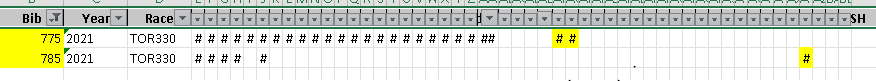

2023
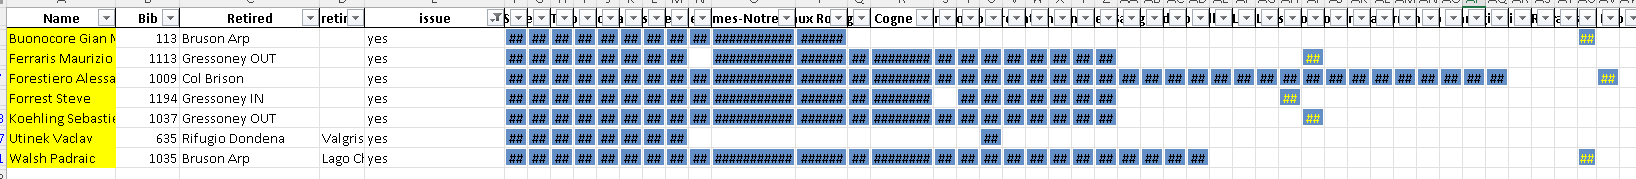

2024

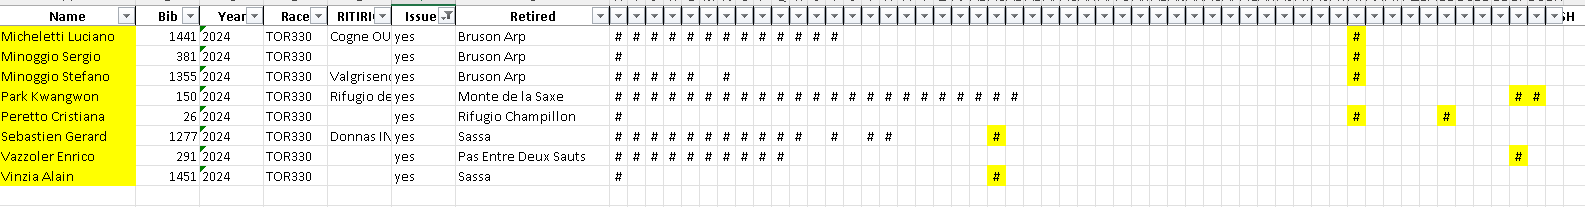

##### Solution
Create a loop that would clean those timestamps.

In [57]:
TORX_list_bib_df = []

melt_TOR330['Status1'] =  melt_TOR330['Status'].astype('str')

for bib in melt_TOR330['Bib'].unique():
    bib_df = melt_TOR330[melt_TOR330['Bib'] == bib].reset_index(drop=True)

    # Check if runner has DNF status
    if bib_df.loc[0, 'Status1'] == 'False':
        n = 0  # Reset counter for missing timestamps

        for idx, row in bib_df.iterrows():
            if pd.isna(row['Timestamp']):
                n += 1
                if n > 5 and idx + 1 < len(bib_df):  # Ensure index is in bounds
                    bib_df.at[idx + 1, 'Timestamp'] = pd.NaT
            else:
                n = 0  # Reset counter if a timestamp appears again

        # Find the last valid aid station with a timestamp
        last_valid_indices = bib_df[bib_df['Timestamp'].notna()].groupby('Bib').tail(1)

        if not last_valid_indices.empty:
            last_aid_station = last_valid_indices['Aid Station'].values[0]
            print(f"Bib {bib}: Retired at {last_aid_station}")

            # Assign the retired location to the entire bib_df
            bib_df['Retired'] = last_aid_station
        else:
            print(f"Warning: No valid aid station found for Bib {bib}")

    else:
        print(f"Bib {bib}: Finished the race")

    # Append processed data
    TORX_list_bib_df.append(bib_df)

# Concatenate all processed bib dataframes
melt_TOR330 = pd.concat(TORX_list_bib_df, ignore_index=True)


Bib 10: Finished the race
Bib 25: Finished the race
Bib 7: Finished the race
Bib 20: Finished the race
Bib 15: Finished the race
Bib 13: Finished the race
Bib 6: Finished the race
Bib 597: Finished the race
Bib 2: Finished the race
Bib 336: Finished the race
Bib 18: Finished the race
Bib 532: Finished the race
Bib 183: Finished the race
Bib 522: Finished the race
Bib 282: Finished the race
Bib 399: Finished the race
Bib 4: Finished the race
Bib 1511: Finished the race
Bib 24: Finished the race
Bib 227: Finished the race
Bib 606: Finished the race
Bib 169: Finished the race
Bib 580: Finished the race
Bib 538: Finished the race
Bib 428: Finished the race
Bib 368: Finished the race
Bib 469: Finished the race
Bib 477: Finished the race
Bib 589: Finished the race
Bib 373: Finished the race
Bib 452: Finished the race
Bib 453: Finished the race
Bib 157: Finished the race
Bib 114: Finished the race
Bib 83: Finished the race
Bib 243: Finished the race
Bib 556: Finished the race
Bib 258: Finishe

Bib 464: Finished the race
Bib 465: Finished the race
Bib 1297: Finished the race
Bib 494: Finished the race
Bib 165: Finished the race
Bib 113: Finished the race
Bib 434: Finished the race
Bib 422: Finished the race
Bib 413: Finished the race
Bib 551: Finished the race
Bib 189: Finished the race
Bib 103: Finished the race
Bib 1400: Finished the race
Bib 1357: Finished the race
Bib 581: Finished the race
Bib 37: Finished the race
Bib 56: Finished the race
Bib 1056: Finished the race
Bib 1049: Finished the race
Bib 1447: Finished the race
Bib 1054: Finished the race
Bib 1505: Finished the race
Bib 1027: Finished the race
Bib 1317: Finished the race
Bib 1073: Finished the race
Bib 1115: Finished the race
Bib 1399: Finished the race
Bib 1229: Finished the race
Bib 1274: Finished the race
Bib 1015: Finished the race
Bib 1486: Finished the race
Bib 1193: Finished the race
Bib 55: Finished the race
Bib 1535: Finished the race
Bib 1176: Finished the race
Bib 1123: Finished the race
Bib 1526: 

Bib 200: Retired at Eaux Rousse
Bib 202: Retired at Donnas IN
Bib 203: Retired at Gressoney OUT
Bib 205: Retired at Bivacco R. Clermont
Bib 207: Retired at Eaux Rousse
Bib 216: Retired at Chalet Epee
Bib 217: Retired at Gressoney OUT
Bib 219: Retired at Ollomont IN
Bib 221: Retired at Start
Bib 224: Retired at Gressoney OUT
Bib 225: Retired at Rifugio Magià
Bib 226: Retired at Gressoney OUT
Bib 228: Retired at Pontboset
Bib 231: Retired at Rifugio Alpenzu
Bib 232: Retired at Bosses
Bib 237: Retired at Eaux Rousse
Bib 240: Retired at Oyace
Bib 241: Retired at Planaval
Bib 247: Retired at Gressoney OUT
Bib 251: Retired at Valgrisenche IN
Bib 254: Retired at Gressoney OUT
Bib 255: Retired at Rhemes-Notre-Dame
Bib 256: Retired at Oyace
Bib 259: Retired at Gressoney OUT
Bib 263: Retired at Ollomont IN
Bib 266: Retired at Bosses
Bib 269: Retired at Champoluc
Bib 275: Retired at Bosses
Bib 278: Retired at Niel La Gruba
Bib 285: Retired at Rifugio Barmasse
Bib 287: Retired at Rifugio Magià
Bib

Bib 1166: Retired at Valgrisenche IN
Bib 1168: Retired at Bruson Arp
Bib 1172: Retired at Valgrisenche OUT
Bib 1173: Retired at Vareton
Bib 1175: Retired at Gressoney OUT
Bib 1177: Retired at La Thuile
Bib 1178: Retired at Rifugio Sella
Bib 1179: Retired at Rifugio Deffeyes
Bib 1180: Retired at Valgrisenche OUT
Bib 1181: Retired at Rhemes-Notre-Dame
Bib 1182: Retired at Valgrisenche OUT
Bib 1184: Retired at Donnas OUT
Bib 1187: Retired at Donnas IN
Bib 1188: Retired at Rifugio Deffeyes
Bib 1189: Retired at Ollomont OUT
Bib 1191: Retired at Niel La Gruba
Bib 1194: Retired at Eaux Rousse
Bib 1195: Retired at Valgrisenche OUT
Bib 1196: Retired at Eaux Rousse
Bib 1197: Retired at Eaux Rousse
Bib 1199: Retired at Rifugio Barmasse
Bib 1201: Retired at Gressoney OUT
Bib 1203: Retired at Perloz
Bib 1205: Retired at La Thuile
Bib 1206: Retired at Gressoney OUT
Bib 1209: Retired at Oyace
Bib 1210: Retired at Niel La Gruba
Bib 1211: Retired at Chalet Epee
Bib 1212: Retired at Rifugio Alpenzu
Bib 

Bib 1567: Retired at Eaux Rousse
Bib 1568: Retired at Rhemes-Notre-Dame
Bib 1569: Retired at Planaval
Bib 1570: Retired at Rhemes-Notre-Dame
Bib 1573: Retired at Niel La Gruba
Bib 1575: Retired at Rifugio Magià


In [58]:
melt_TOR330.shape

(54750, 15)

In [59]:
melt_TOR330[melt_TOR330['Bib'] == '10']

,Year,Race,Name,Bib,Sex,Nationality,Category,Status,Wave,Duration,Aid Station,Timestamp,PK,Status1,Retired
0,2024,TOR330,D Haene Francois,10,M,FR,SEN,True,Wave1,2 days 21:08:32,Start,2024-09-08 10:00:00,TOR330_2024_10,True,NaN
1,2024,TOR330,D Haene Francois,10,M,FR,SEN,True,Wave1,2 days 21:08:32,Baite Youlaz,2024-09-08 11:51:50,TOR330_2024_10,True,NaN
2,2024,TOR330,D Haene Francois,10,M,FR,SEN,True,Wave1,2 days 21:08:32,La Thuile,2024-09-08 12:19:14,TOR330_2024_10,True,NaN
3,2024,TOR330,D Haene Francois,10,M,FR,SEN,True,Wave1,2 days 21:08:32,Rifugio Deffeyes,2024-09-08 13:41:37,TOR330_2024_10,True,NaN
4,2024,TOR330,D Haene Francois,10,M,FR,SEN,True,Wave1,2 days 21:08:32,Planaval,2024-09-08 16:24:18,TOR330_2024_10,True,NaN
5,2024,TOR330,D Haene Francois,10,M,FR,SEN,True,Wave1,2 days 21:08:32,Valgrisenche IN,2024-09-08 17:04:36,TOR330_2024_10,True,NaN
6,2024,TOR330,D Haene Francois,10,M,FR,SEN,True,Wave1,2 days 21:08:32,Valgrisenche OUT,2024-09-08 17:05:13,TOR330_2024_10,True,NaN
7,2024,TOR330,D Haene Francois,10,M,FR,SEN,True,Wave1,2 days 21:08:32,Chalet Epee,2024-09-08 18:09:57,TOR330_2024_10,True,NaN
8,2024,TOR330,D Haene Francois,10,M,FR,SEN,True,Wave1,2 days 21:08:32,Rhemes-Notre-Dame,2024-09-08 19:24:40,TOR330_2024_10,True,NaN
9,2024,TOR330,D Haene Francois,10,M,FR,SEN,True,Wave1,2 days 21:08:32,Eaux Rousse,2024-09-08 22:12:29,TOR330_2024_10,True,NaN


###  Unpredictable Weather of 2022 
In 2022, due to the weather,  the race directors decided to stop the race at Bosses and Refuge Frassati.  

In [60]:

for year in years:
    if year == '2022':
        
        for retired_location in melt_TOR330['Retired'].unique():
            if pd.isna(retired_location):
                # Update 'Status1' for year 2022
                melt_TOR330.loc[
                    melt_TOR330['Year'] == year, 'Status1'
                ] = melt_TOR330.loc[
                    melt_TOR330['Year'] == year, 'Status1'
                ].str.replace('True', 'Finished at Courmayeur')
                
            elif retired_location == 'Rifugio Frassati' or retired_location == 'Bosses':
                # For finishers at Rifugio Frassati
                melt_TOR330.loc[
                    (melt_TOR330['Year'] == year) & (melt_TOR330['Retired'] == retired_location), 'Status1'
                ] = melt_TOR330.loc[
                    (melt_TOR330['Year'] == year) & (melt_TOR330['Retired'] == retired_location), 'Status1'
                ].str.replace('False', f'Finished at {retired_location}')

                melt_TOR330.loc[
                    (melt_TOR330['Year'] == year) & (melt_TOR330['Retired'] == retired_location), 'Retired'
                ] = np.nan
                
            else:
                # Allother DNFs
                melt_TOR330.loc[
                    (melt_TOR330['Year'] == year)
                    & ~(melt_TOR330['Retired'].isin(['Bosses', 'Rifugio Frassati'])), 'Status1'
                ] = melt_TOR330.loc[
                    (melt_TOR330['Year'] == year)
                    & ~(melt_TOR330['Retired'].isin(['Bosses', 'Rifugio Frassati'])), 'Status1'
                ].str.replace('False', 'DNF')

    else:
        
        print(year)
        # Update 'Status1' for years other than 2022
        melt_TOR330.loc[melt_TOR330['Year'] == year, 'Status1'] = (
            melt_TOR330.loc[melt_TOR330['Year'] == year, 'Status1']
            .str.replace('True', 'Finished at Courmayeur')
            .str.replace('False', 'DNF')
        )
        print(melt_TOR330['Status1'].unique())

2024
['Finished at Courmayeur' 'DNF']


In [61]:
counting_finish_DNF_dataset(pivoted_TOR330_dates)
find_out_the_rows_difference_between_datasets(pivoted_TOR330_dates)


TOR330 2024
# of Partipants: 1095
# of Finishers: 533
# of DNFs: 562
********************
TOR330 2024
# ITRA rows:  533
# DUV rows:  533
# TOR330 rows:  533

 ********************


In [62]:
melt_TOR330.groupby('Status1')['Status1'].count()

Status1
DNF                       28100
Finished at Courmayeur    26650
Name: Status1, dtype: int64

### Where did the DNFs occur?

In [63]:
melt_TOR330['Retired'] = melt_TOR330['Retired'].str.replace(' IN', '')
melt_TOR330['Retired'] = melt_TOR330['Retired'].str.replace(' OUT', '')

In [64]:
Stage1 = [ 'Start', 'Baite Youlaz', 'La Thuile', 'Rifugio Deffeyes',\
          'Planaval', 'Valgrisenche IN', 'Valgrisenche']
Stage2 = [ 'Valgrisenche OUT', 'Chalet Epee',\
          'Rhemes-Notre-Dame', 'Eaux Rousse', 'Rifugio Sella', 'Cogne IN', 'Cogne']
Stage3 = [  'Cogne OUT', 'Goilles', 'Rifugio Dondena', 'Chardonney', 'Pontboset','Donnas IN', 'Donnas']
Stage4 = [  'Donnas OUT', 'Perloz', 'Sassa', 'Rifugio Coda', \
          'Rifugio della Barma', 'Lago Chiaro', 'Col della Vecchia',\
          'Niel La Gruba', 'Loo', 'Gressoney IN', 'Gressoney']
Stage5 = [  'Gressoney OUT', 'Rifugio Alpenzu', 'Champoluc' ,\
          'Rifugio Grand Tournalin', 'Valtournenche IN' ,'Valtournenche']
Stage6 = [   'Valtournenche OUT', 'Rifugio Barmasse', 'Vareton',\
          'Rifugio Magià', 'Rifugio Cuney', 'Bivacco R. Clermont', 'Oyace', \
          'Bruson Arp', 'Ollomont IN', 'Ollomont']    
Stage7 = [ 'Ollomont OUT', 'Rifugio Champillon', 'Ponteille Desot',\
          'Bosses', 'Rifugio Frassati', 'Pas Entre Deux Sauts',\
          'Monte de la Saxe', 'FINISH']

stages =[ Stage1, Stage2, Stage3, Stage4, Stage5, Stage6, Stage7]
stages_str =[ 'Stage 1', 'Stage 2', 'Stage 3', 'Stage 4', 'Stage 5', 'Stage 6', 'Stage 7']
for stage,  stage_str in zip(stages, stages_str):
    melt_TOR330.loc[melt_TOR330['Retired'].isin(stage), 'Retired_Stage'] = f'{stage_str}'
        
melt_TOR330.loc[melt_TOR330['Retired'] == 'Start Date', 'Retired_Stage'] = 'DNS'
melt_TOR330[melt_TOR330['Bib'] == '10']

,Year,Race,Name,Bib,Sex,Nationality,Category,Status,Wave,Duration,Aid Station,Timestamp,PK,Status1,Retired,Retired_Stage
0,2024,TOR330,D Haene Francois,10,M,FR,SEN,True,Wave1,2 days 21:08:32,Start,2024-09-08 10:00:00,TOR330_2024_10,Finished at Courmayeur,NaN,NaN
1,2024,TOR330,D Haene Francois,10,M,FR,SEN,True,Wave1,2 days 21:08:32,Baite Youlaz,2024-09-08 11:51:50,TOR330_2024_10,Finished at Courmayeur,NaN,NaN
2,2024,TOR330,D Haene Francois,10,M,FR,SEN,True,Wave1,2 days 21:08:32,La Thuile,2024-09-08 12:19:14,TOR330_2024_10,Finished at Courmayeur,NaN,NaN
3,2024,TOR330,D Haene Francois,10,M,FR,SEN,True,Wave1,2 days 21:08:32,Rifugio Deffeyes,2024-09-08 13:41:37,TOR330_2024_10,Finished at Courmayeur,NaN,NaN
4,2024,TOR330,D Haene Francois,10,M,FR,SEN,True,Wave1,2 days 21:08:32,Planaval,2024-09-08 16:24:18,TOR330_2024_10,Finished at Courmayeur,NaN,NaN
5,2024,TOR330,D Haene Francois,10,M,FR,SEN,True,Wave1,2 days 21:08:32,Valgrisenche IN,2024-09-08 17:04:36,TOR330_2024_10,Finished at Courmayeur,NaN,NaN
6,2024,TOR330,D Haene Francois,10,M,FR,SEN,True,Wave1,2 days 21:08:32,Valgrisenche OUT,2024-09-08 17:05:13,TOR330_2024_10,Finished at Courmayeur,NaN,NaN
7,2024,TOR330,D Haene Francois,10,M,FR,SEN,True,Wave1,2 days 21:08:32,Chalet Epee,2024-09-08 18:09:57,TOR330_2024_10,Finished at Courmayeur,NaN,NaN
8,2024,TOR330,D Haene Francois,10,M,FR,SEN,True,Wave1,2 days 21:08:32,Rhemes-Notre-Dame,2024-09-08 19:24:40,TOR330_2024_10,Finished at Courmayeur,NaN,NaN
9,2024,TOR330,D Haene Francois,10,M,FR,SEN,True,Wave1,2 days 21:08:32,Eaux Rousse,2024-09-08 22:12:29,TOR330_2024_10,Finished at Courmayeur,NaN,NaN


In [65]:
# making sure that I caught all aid stations!!!!
melt_TOR330[
    (melt_TOR330['Status1'] == False) &
    
    (melt_TOR330['Retired_Stage'].isnull())
                    ]

,Year,Race,Name,Bib,Sex,Nationality,Category,Status,Wave,Duration,Aid Station,Timestamp,PK,Status1,Retired,Retired_Stage


In [66]:
melt_TOR330['Retired_Stage'].unique()

array([nan, 'Stage 1', 'Stage 2', 'Stage 3', 'Stage 5', 'Stage 4',
       'Stage 7', 'Stage 6'], dtype=object)

In [67]:
# DNS
melt_TOR330[melt_TOR330['Retired'] == 'Start']

,Year,Race,Name,Bib,Sex,Nationality,Category,Status,Wave,Duration,Aid Station,Timestamp,PK,Status1,Retired,Retired_Stage
26650,2024,TOR330,Colle Franco,1,M,IT,V1,False,Wave1,NaT,Start,2024-09-08 10:00:00,TOR330_2024_1,DNF,Start,Stage 1
26651,2024,TOR330,Colle Franco,1,M,IT,V1,False,Wave1,NaT,Baite Youlaz,NaT,TOR330_2024_1,DNF,Start,Stage 1
26652,2024,TOR330,Colle Franco,1,M,IT,V1,False,Wave1,NaT,La Thuile,NaT,TOR330_2024_1,DNF,Start,Stage 1
26653,2024,TOR330,Colle Franco,1,M,IT,V1,False,Wave1,NaT,Rifugio Deffeyes,NaT,TOR330_2024_1,DNF,Start,Stage 1
26654,2024,TOR330,Colle Franco,1,M,IT,V1,False,Wave1,NaT,Planaval,NaT,TOR330_2024_1,DNF,Start,Stage 1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52745,2024,TOR330,Balestri Michele,1508,M,IT,V2,False,Wave2,NaT,Bosses,NaT,TOR330_2024_1508,DNF,Start,Stage 1
52746,2024,TOR330,Balestri Michele,1508,M,IT,V2,False,Wave2,NaT,Rifugio Frassati,NaT,TOR330_2024_1508,DNF,Start,Stage 1
52747,2024,TOR330,Balestri Michele,1508,M,IT,V2,False,Wave2,NaT,Pas Entre Deux Sauts,NaT,TOR330_2024_1508,DNF,Start,Stage 1
52748,2024,TOR330,Balestri Michele,1508,M,IT,V2,False,Wave2,NaT,Monte de la Saxe,NaT,TOR330_2024_1508,DNF,Start,Stage 1


In [68]:
melt_TOR330.head(1)

,Year,Race,Name,Bib,Sex,Nationality,Category,Status,Wave,Duration,Aid Station,Timestamp,PK,Status1,Retired,Retired_Stage
0,2024,TOR330,D Haene Francois,10,M,FR,SEN,True,Wave1,2 days 21:08:32,Start,2024-09-08 10:00:00,TOR330_2024_10,Finished at Courmayeur,NaN,NaN


### Sub-Finish Category

I labelled the Finisher's Sub-130 Finish times
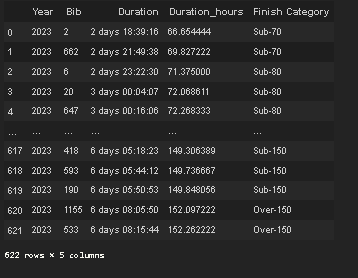

In [69]:
# Convert to timedelta and get total hours (handling NaT)
melt_TOR330['Duration_hours'] = pd.to_timedelta(
    melt_TOR330['Duration'], errors='coerce').dt.total_seconds() / 3600  # Convert seconds to hours


# Create a new column 'Finish Category'
def categorize_duration(hours):
    if pd.isna(hours):
        return 'DNF'  # Handle NaT values
    elif hours < 50:
        return 'Sub-50'
    elif hours <= 150:
        return f'Sub-{int(hours // 10) * 10 + 10}'  # Round to nearest 10 up to 150
    else:
        return 'Over-150'
    
# Apply categorization with proper indexing
if year == '2022':
    mask = melt_TOR330['Status1'].str.contains('Courmayeur', na=False)
    melt_TOR330.loc[mask, 'Finish Category'] = melt_TOR330.loc[mask, 'Duration_hours'].apply(categorize_duration)
else:
    melt_TOR330['Finish Category'] = melt_TOR330['Duration_hours'].apply(categorize_duration)


# Define the desired order of categories
finish_category_order = [
    'Sub-50','Sub-60',
    'Sub-70','Sub-80','Sub-90', 'Sub-100', 'Sub-110', 'Sub-120',
    'Sub-130', 'Sub-140', 'Sub-150', 'Over-150', 'DNF'
]

# Set 'Finish Category' as a categorical column with the defined order
melt_TOR330['Finish Category'] = pd.Categorical(
    melt_TOR330['Finish Category'],
    categories = finish_category_order,
    ordered = True
)


# Display the DataFrame
melt_TOR330[['Year','Bib', 'Duration', 'Duration_hours', 'Finish Category']]

    

,Year,Bib,Duration,Duration_hours,Finish Category
0,2024,10,2 days 21:08:32,69.142222,Sub-70
1,2024,10,2 days 21:08:32,69.142222,Sub-70
2,2024,10,2 days 21:08:32,69.142222,Sub-70
3,2024,10,2 days 21:08:32,69.142222,Sub-70
4,2024,10,2 days 21:08:32,69.142222,Sub-70
...,...,...,...,...,...
54745,2024,1575,NaT,NaN,DNF
54746,2024,1575,NaT,NaN,DNF
54747,2024,1575,NaT,NaN,DNF
54748,2024,1575,NaT,NaN,DNF


# Demographic data

In [70]:
TOR330_dem = melt_TOR330.copy()

TOR330_dem['Duration_seconds'] = pd.to_timedelta(
    TOR330_dem['Duration'], errors='coerce'
).dt.total_seconds()

TOR330_dem = TOR330_dem[[ 'PK','Year', 'Race', 'Name', 'Bib', 'Sex', 'Nationality',  'Category',
       'Status', 'Status1', 'Wave', 'Duration_seconds', 'Retired', 'Retired_Stage','Finish Category'  ]]
TOR330_dem = TOR330_dem.drop_duplicates(keep='first')

TOR330_dem = TOR330_dem.reset_index(drop = True)

TOR330_dem[TOR330_dem['Bib'] == '10']

,PK,Year,Race,Name,Bib,Sex,Nationality,Category,Status,Status1,Wave,Duration_seconds,Retired,Retired_Stage,Finish Category
0,TOR330_2024_10,2024,TOR330,D Haene Francois,10,M,FR,SEN,True,Finished at Courmayeur,Wave1,248912.0,NaN,NaN,Sub-70


In [71]:
melt_TOR330 = melt_TOR330[['PK', 'Year', 'Race', 'Bib', 
             'Status',  'Status1', 'Retired', 'Wave',
             'Aid Station', 'Timestamp',   'Finish Category'] ]

## Lifebase Data

In [72]:
melt_lifebase_df = melt_TOR330 [melt_TOR330['Aid Station'].isin(lifebase_category_order)]

# Set 'Finish Category' as a categorical column with the defined order
melt_lifebase_df['Aid Station'] = pd.Categorical(
        melt_lifebase_df['Aid Station'],
        categories = lifebase_category_order,
        ordered = True)
melt_lifebase_df = melt_lifebase_df.rename(columns={"Aid Station": "Lifebase"}) 

melt_lifebase_df[melt_lifebase_df['Bib'] == '10']

C:\Users\Karina\AppData\Local\Temp\ipykernel_21692\3815309605.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  melt_lifebase_df['Aid Station'] = pd.Categorical(


,PK,Year,Race,Bib,Status,Status1,Retired,Wave,Lifebase,Timestamp,Finish Category
0,TOR330_2024_10,2024,TOR330,10,True,Finished at Courmayeur,NaN,Wave1,Start,2024-09-08 10:00:00,Sub-70
5,TOR330_2024_10,2024,TOR330,10,True,Finished at Courmayeur,NaN,Wave1,Valgrisenche IN,2024-09-08 17:04:36,Sub-70
6,TOR330_2024_10,2024,TOR330,10,True,Finished at Courmayeur,NaN,Wave1,Valgrisenche OUT,2024-09-08 17:05:13,Sub-70
11,TOR330_2024_10,2024,TOR330,10,True,Finished at Courmayeur,NaN,Wave1,Cogne IN,2024-09-09 02:44:15,Sub-70
12,TOR330_2024_10,2024,TOR330,10,True,Finished at Courmayeur,NaN,Wave1,Cogne OUT,2024-09-09 02:45:30,Sub-70
17,TOR330_2024_10,2024,TOR330,10,True,Finished at Courmayeur,NaN,Wave1,Donnas IN,2024-09-09 10:35:50,Sub-70
18,TOR330_2024_10,2024,TOR330,10,True,Finished at Courmayeur,NaN,Wave1,Donnas OUT,2024-09-09 10:36:31,Sub-70
27,TOR330_2024_10,2024,TOR330,10,True,Finished at Courmayeur,NaN,Wave1,Gressoney IN,2024-09-09 23:15:19,Sub-70
28,TOR330_2024_10,2024,TOR330,10,True,Finished at Courmayeur,NaN,Wave1,Gressoney OUT,2024-09-10 01:07:47,Sub-70
32,TOR330_2024_10,2024,TOR330,10,True,Finished at Courmayeur,NaN,Wave1,Valtournenche IN,2024-09-10 08:44:39,Sub-70


### Checkpoints

In [73]:

checkpoint_category_order = [
    'Start',
       'La Thuile', 'Valgrisenche IN', 'Valgrisenche OUT',
       'Eaux Rousse', 'Cogne IN', 'Cogne OUT', 'Donnas IN', 'Donnas OUT',
       'Rifugio della Barma', 'Niel La Gruba', 'Gressoney IN',
       'Gressoney OUT', 'Champoluc', 'Valtournenche IN',
       'Valtournenche OUT', 'Oyace', 'Ollomont IN', 'Ollomont OUT',
       'FINISH']

melt_checkpoint_df = melt_TOR330 [melt_TOR330['Aid Station'].isin(checkpoint_category_order)]

# Set 'Finish Category' as a categorical column with the defined order
melt_checkpoint_df['Aid Station'] = pd.Categorical(
        melt_checkpoint_df['Aid Station'],
        categories = checkpoint_category_order,
        ordered = True)
melt_checkpoint_df = melt_checkpoint_df.rename(columns={"Aid Station": "Checkpoint"}) 

melt_checkpoint_df[melt_checkpoint_df['Bib'] == '10']

C:\Users\Karina\AppData\Local\Temp\ipykernel_21692\4210540530.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  melt_checkpoint_df['Aid Station'] = pd.Categorical(


,PK,Year,Race,Bib,Status,Status1,Retired,Wave,Checkpoint,Timestamp,Finish Category
0,TOR330_2024_10,2024,TOR330,10,True,Finished at Courmayeur,NaN,Wave1,Start,2024-09-08 10:00:00,Sub-70
2,TOR330_2024_10,2024,TOR330,10,True,Finished at Courmayeur,NaN,Wave1,La Thuile,2024-09-08 12:19:14,Sub-70
5,TOR330_2024_10,2024,TOR330,10,True,Finished at Courmayeur,NaN,Wave1,Valgrisenche IN,2024-09-08 17:04:36,Sub-70
6,TOR330_2024_10,2024,TOR330,10,True,Finished at Courmayeur,NaN,Wave1,Valgrisenche OUT,2024-09-08 17:05:13,Sub-70
9,TOR330_2024_10,2024,TOR330,10,True,Finished at Courmayeur,NaN,Wave1,Eaux Rousse,2024-09-08 22:12:29,Sub-70
11,TOR330_2024_10,2024,TOR330,10,True,Finished at Courmayeur,NaN,Wave1,Cogne IN,2024-09-09 02:44:15,Sub-70
12,TOR330_2024_10,2024,TOR330,10,True,Finished at Courmayeur,NaN,Wave1,Cogne OUT,2024-09-09 02:45:30,Sub-70
17,TOR330_2024_10,2024,TOR330,10,True,Finished at Courmayeur,NaN,Wave1,Donnas IN,2024-09-09 10:35:50,Sub-70
18,TOR330_2024_10,2024,TOR330,10,True,Finished at Courmayeur,NaN,Wave1,Donnas OUT,2024-09-09 10:36:31,Sub-70
22,TOR330_2024_10,2024,TOR330,10,True,Finished at Courmayeur,NaN,Wave1,Rifugio della Barma,2024-09-09 17:00:11,Sub-70


## Who missed the Checkpoint Cut OFFs?

## Cutoffs
The cutoffs table was used to establish whether individuals missed the cutoffs or not.


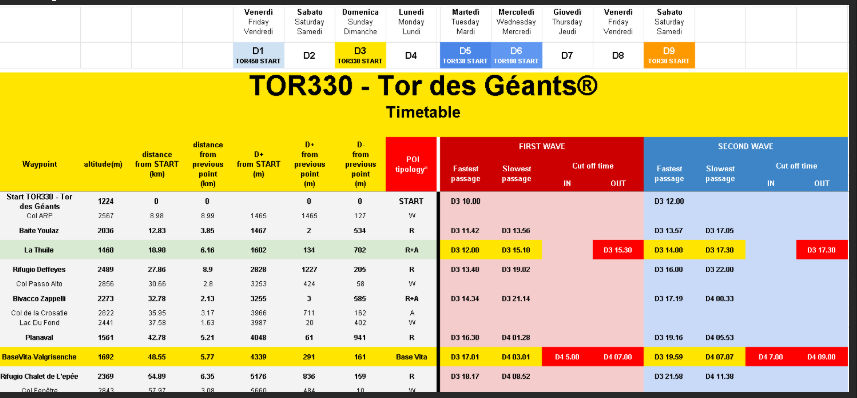


#### Stage Cutoffs
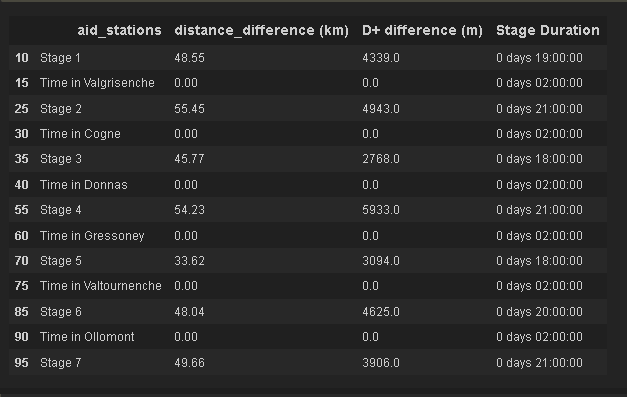

After cleaning the CSV and attaching dates instead of D1/ D2/ D3 etc, this is what the cut off talbe looks like:

#### Dates Cutoffs
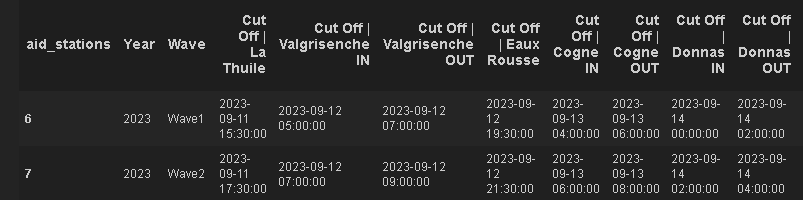

In [74]:
# Saving this 
lifebase_cut_offs_df = pd.read_excel(f'{race} Data/4. TOR330 Timetable Data/{race}_lifebase_cut_offs_df.xlsx')

# # # Convert integer seconds to timedelta
lifebase_cut_offs_df['Lifebase Duration'] = pd.to_timedelta(lifebase_cut_offs_df['Lifebase Duration_seconds'], unit='s')

# # # Convert integer seconds to timedelta
lifebase_cut_offs_df['Running Total Lifebase Duration'] = pd.to_timedelta(lifebase_cut_offs_df['Running Total Lifebase Duration_seconds'], unit='s')

lifebase_cut_offs_df = lifebase_cut_offs_df[['Lifebase', 'Stage', 'Lifebase Duration','Running Total Lifebase Duration']]



In [75]:
# Saving this # Saving this 
aid_station_cut_offs_df = pd.read_excel(f'{race} Data/4. TOR330 Timetable Data/{race}_aid_station_cut_offs_df.xlsx')

# # # # Convert integer seconds to timedelta
aid_station_cut_offs_df['Checkpoint Duration'] = pd.to_timedelta(aid_station_cut_offs_df['Checkpoint Duration_seconds'], unit='s')

# # # Convert integer seconds to timedelta
aid_station_cut_offs_df['Running Total Checkpoint Duration'] = pd.to_timedelta(aid_station_cut_offs_df['Running Total Checkpoint Duration_seconds'], unit='s')

aid_station_cut_offs_df = aid_station_cut_offs_df[['Checkpoint', 'Stage', 'Checkpoint Duration','Running Total Checkpoint Duration']]
aid_station_cut_offs_df



,Checkpoint,Stage,Checkpoint Duration,Running Total Checkpoint Duration
0,NaN,Stage 1,NaT,NaT
1,La Thuile,Stage 1,0 days 05:30:00,0 days 05:30:00
2,NaN,Stage 1,NaT,NaT
3,NaN,Stage 1,NaT,NaT
4,Valgrisenche IN,Stage 1,0 days 13:30:00,0 days 19:00:00
5,Valgrisenche OUT,Time Spent in Valgrisenche,0 days 02:00:00,0 days 21:00:00
6,NaN,Stage 2,NaT,NaT
7,NaN,Stage 2,NaT,NaT
8,Eaux Rousse,Stage 2,0 days 12:30:00,1 days 09:30:00
9,NaN,Stage 2,NaT,NaT


In [76]:
# Saving this 
checkpoints_cut_offs_df = pd.read_excel(f'{race} Data/4. TOR330 Timetable Data/{race}_checkpoint_cut_offs_df.xlsx')

# # # Convert integer seconds to timedelta
checkpoints_cut_offs_df['Checkpoint Duration'] = pd.to_timedelta(checkpoints_cut_offs_df['Checkpoint Duration_seconds'], unit='s')

# # # Convert integer seconds to timedelta
checkpoints_cut_offs_df['Running Total Checkpoint Duration'] = pd.to_timedelta(checkpoints_cut_offs_df['Running Total Checkpoint Duration_seconds'], unit='s')

checkpoints_cut_offs_df = checkpoints_cut_offs_df[['Checkpoint', 'Stage', 'Checkpoint Duration','Running Total Checkpoint Duration']]
checkpoints_cut_offs_df


,Checkpoint,Stage,Checkpoint Duration,Running Total Checkpoint Duration
0,La Thuile,Stage 1,0 days 05:30:00,0 days 05:30:00
1,Valgrisenche IN,Stage 1,0 days 13:30:00,0 days 19:00:00
2,Valgrisenche OUT,Time Spent in Valgrisenche,0 days 02:00:00,0 days 21:00:00
3,Eaux Rousse,Stage 2,0 days 12:30:00,1 days 09:30:00
4,Cogne IN,Stage 2,0 days 08:30:00,1 days 18:00:00
5,Cogne OUT,Time Spent in Cogne,0 days 02:00:00,1 days 20:00:00
6,Donnas IN,Stage 3,0 days 18:00:00,2 days 14:00:00
7,Donnas OUT,Time Spent in Donnas,0 days 02:00:00,2 days 16:00:00
8,Rifugio della Barma,Stage 4,0 days 11:00:00,3 days 03:00:00
9,Niel La Gruba,Stage 4,0 days 06:30:00,3 days 09:30:00


In [77]:
cutoffs_df_pivot = pd.read_excel(f'{race} Data/4. TOR330 Timetable Data/{race}_aid_station_for_each_year_cut_offs_df.xlsx')
cutoffs_df_pivot['Year'] = cutoffs_df_pivot['Year'].astype('int')
cutoffs_df_pivot['Year'] = cutoffs_df_pivot['Year'].astype('str')
cutoffs_df_pivot = cutoffs_df_pivot[cutoffs_df_pivot['Year'] == year]


if year == '2021':
    cutoffs_df_pivot = cutoffs_df_pivot[cutoffs_df_pivot['Wave'] == 'Wave1']
    cutoffs_df_pivot['Wave'] = 'No Wave in 2021'
    
cutoffs_df_pivot.columns

Index(['Checkpoint', 'Year', 'Wave', 'Cut Off Date', 'Stage'], dtype='object')

### Looking for the Polish Fella!

When I ran TOR 2023, I distingly remember running into a Polish fella as I was leaving Gressoney. I was hiking with him from Rifugio Barma, he was in Wave 1. I remember running up to him at the lifebase, all excited "Hey, you made it!"

The reply I recieved was "WHat are you talking about? I missed the cutoff"

So I began looking for him to find out why I dont have more people who missed the cut off!

Here I am leaving Gressoney!

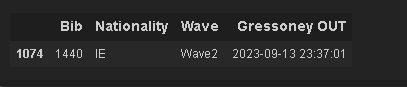

This is the cut off times
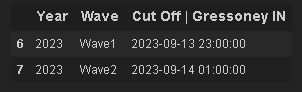

I looked for all the Poles that DNFed the race

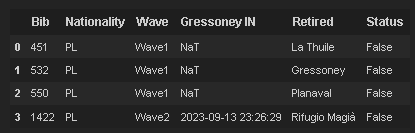

It is clear that he DNFed at 'Gressoney OUT - RITIRIO' 
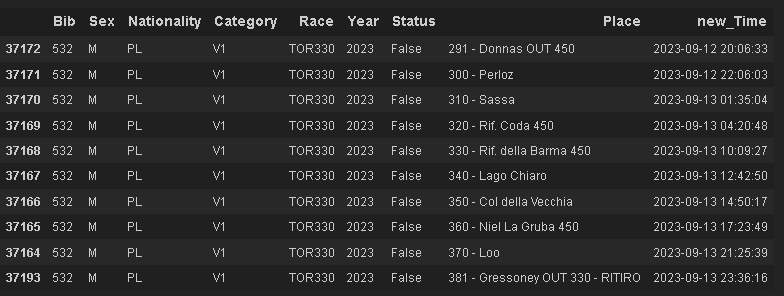
This is what is causing my heartache!



### SOLUTION
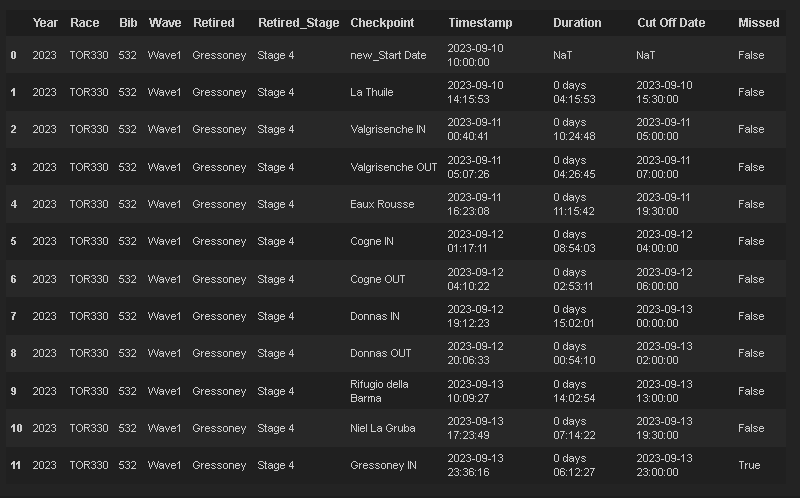


## Missed Cut Off - Function

In [78]:
def checking_cut_offs(df, column, stats_cut_offs_df):
    # Examining only finishers
    TORX_list = []
    n=0


    for unique_bib in df['Bib'].unique(): 

        # Filter the dataframe for the current unique_bib
        bib_df = df[df['Bib'] == unique_bib].reset_index(drop = True)

        retired_location = TOR330_dem['Retired'][TOR330_dem['Bib'] == unique_bib].values[0]
        n = n+1
        print(n, f'Processing Bib: {unique_bib}')
        # Ensure retired_location is not NaN
        if pd.isna(retired_location):
    #         print(retired_location)
            # Example: Calculating duration for finished participants
            bib_df['Duration'] = bib_df['Timestamp'].diff()
        else:

            # FIxing the Polish fella issue!
            retired_location = TOR330_dem['Retired'][TOR330_dem['Bib'] == unique_bib].values[0]
    #         print(f"Processing Bib: {unique_bib}, Retired Location: {retired_location}")
    #         print(bib_df[column].nunique())


            # Iterate over the rows to process the data
            for idx, row in bib_df.iterrows():
                checkpoint = bib_df.at[idx, column]

                ############ FIXING THE POLISH MAN 532 issue!
                if retired_location in checkpoint:
                    # Check if the checkpoint does not contain 'OUT' or 'IN'
                    if 'OUT' in  checkpoint or 'IN' in checkpoint:

                        # If the checkpoint is retired_location + 'IN' and Timestamp is NaN
                        if checkpoint == f"{retired_location} IN" and pd.isna(row['Timestamp']):
                            # Locate the 'OUT' checkpoint row
                            out_row = bib_df[bib_df[column] == f"{retired_location} OUT"]
                            # Use the Timestamp from 'OUT'
                            bib_df.at[idx, 'Timestamp'] = out_row['Timestamp'].values[0]

                            # Make the next Timestamp Nan
                            bib_df.at[idx +1, 'Timestamp'] = pd.NaT
                            print(idx, idx+1)

        bib_df['Duration'] = bib_df['Timestamp'].diff()    
        
        bib_df['Duration_seconds'] = pd.to_timedelta( bib_df['Duration'], errors='coerce').dt.total_seconds()
    
        # Extract the start date timestamp
        bib_start_date = bib_df.loc[bib_df[column] == "Start", 'Timestamp'].values[0]

        # Calculate running total duration
        bib_df['Running Total Duration'] = bib_df['Timestamp'] - bib_start_date

        # Convert duration to seconds
        bib_df['Running Total Duration_seconds'] = pd.to_timedelta(
            bib_df['Running Total Duration'], errors='coerce'
        ).dt.total_seconds()


        # Append the processed DataFrame to the list
        TORX_list.append(bib_df)
    #     print(f"Processed {n} Bib(s).", unique_bib)

    # Combine all results into one DataFrame
    if TORX_list:
        final_df = pd.concat(TORX_list, ignore_index=True)
        print("Combined DataFrame created.")
    else:
        final_df = pd.DataFrame()
        print("No DataFrames were processed.")

    print(final_df.columns)
    print(cutoffs_df_pivot.columns)
    
    if column == 'Checkpoint':

        final_df = final_df.merge(
            cutoffs_df_pivot,
            on=[column, 'Wave', 'Year'],
            how='left')
        
            
        final_df['Missed Last Checkpoint'] = np.where(
            ((final_df['Checkpoint'] == final_df['Retired'] + ' IN') |
            (final_df['Checkpoint'] == final_df['Retired'] + ' OUT')) &
            (final_df['Timestamp'] > final_df['Cut Off Date'] ),
            True,
            False
        ) 
        
        final_df = final_df.merge(
            stats_cut_offs_df[[column, f'{column} Duration']],
            on=column,
            how='left')    
        final_df['Missed Lifebase Allocated Time'] = np.where(
             final_df['Duration'] > final_df[f'{column} Duration'],
             'Outside Allocated Time ',
             'Within Allocated Time') 
        
        print( '\n', final_df[final_df['Bib'] == 1], '\n')
        

        
    elif column == 'Lifebase':
        final_df = final_df.rename(columns={"Lifebase": "Checkpoint"}) 

        print(f'column == {column}')
        final_df = final_df.merge(
            cutoffs_df_pivot,
            right_on=['Checkpoint', 'Wave', 'Year'],
            left_on=['Checkpoint', 'Wave', 'Year'],
            how='left')       
        final_df = final_df.rename(columns={"Checkpoint": "Lifebase"}) 
        
        final_df['Missed Last Checkpoint'] = np.where(
            ((final_df['Lifebase'] == final_df['Retired'] + ' IN') |
            (final_df['Lifebase'] == final_df['Retired'] + ' OUT')) &
            (final_df['Timestamp'] > final_df['Cut Off Date'] ),
            True,
            False
        ) 
        
        final_df = final_df.merge(
            stats_cut_offs_df[[column, f'{column} Duration']],
            on=column,
            how='left')  
        
        final_df['Missed Lifebase Allocated Time'] = np.where(
             final_df['Duration'] > final_df[f'{column} Duration'],
             'Outside Allocated Time ',
             'Within Allocated Time') 


    elif column == 'Aid Station':
        final_df = final_df.rename(columns={"Aid Station": "Checkpoint"}) 

        print(f'column == {column}')
        final_df = final_df.merge(
            cutoffs_df_pivot,
            right_on=['Checkpoint', 'Wave', 'Year'],
            left_on=['Checkpoint', 'Wave', 'Year'],
            how='left')       
    
        final_df = final_df.merge(
            stats_cut_offs_df[['Checkpoint', f'Checkpoint Duration']],
            on=['Checkpoint'],
            how='left') 
    
        final_df['Missed Lifebase Allocated Time'] = np.where(
             final_df['Duration'] > final_df[f'Checkpoint Duration'],
             'Outside Allocated Time ',
             'Within Allocated Time')  
    
    
        final_df = final_df.rename(columns={"Checkpoint": "Aid Station"})
    
    
        
        final_df['Missed Last Checkpoint'] = np.where(
            ((final_df['Aid Station'] == final_df['Retired'] + ' IN') |
            (final_df['Aid Station'] == final_df['Retired'] + ' OUT')) &
            (final_df['Timestamp'] > final_df['Cut Off Date'] ),
            True,
            False
        )  
    else:
        print('BOo')


            # Compare 'Timestamp' with the cutoff
    final_df['Missed'] = final_df['Timestamp'] >   final_df['Cut Off Date']
    final_df['Missed Diff'] = np.where(
        final_df['Timestamp'] > final_df['Cut Off Date'],
        final_df['Timestamp'] - final_df['Cut Off Date'],
        pd.NaT  # Ensure missing values are compatible with timedelta64
    )
    
    print(final_df[final_df['Timestamp'] > final_df['Cut Off Date']])

    # Explicitly cast 'Missed Diff' to timedelta64[ns] to enforce the type
    final_df['Missed Diff'] = final_df['Missed Diff'].astype('timedelta64[ns]')
#     final_df['Missed Last Checkpoint'] = final_df['Missed Last Checkpoint'].fillna(False)

    
    # tableau prep
    final_df['Missed Diff_seconds'] = pd.to_timedelta(
        final_df['Missed Diff'], errors='coerce').dt.total_seconds()
    
    
    

    if column  == 'Checkpoint':
        final_df['Missed Last Checkpoint'][~(final_df['Missed Diff'].isna()) &
                            ~(final_df['Retired'].isna()) &
                            ~(final_df['Checkpoint' ].str.contains(' OUT')) &
                            ~(final_df['Checkpoint' ].str.contains(' IN')) &
                            ( final_df['Checkpoint' ] ==  final_df['Retired'])] = True  

    elif column == 'Aid Station':
        final_df['Missed Last Checkpoint'][~(final_df['Missed Diff'].isna()) &
                                ~(final_df['Retired'].isna()) &
                                ~(final_df['Aid Station' ].str.contains(' OUT')) &
                                ~(final_df['Aid Station' ].str.contains(' IN')) &
                                ( final_df['Aid Station' ] ==  final_df['Retired'])] = True 

    return final_df

### Checkpoints

In [79]:
melt_checkpoint_df[melt_checkpoint_df['Bib'] == '10']

,PK,Year,Race,Bib,Status,Status1,Retired,Wave,Checkpoint,Timestamp,Finish Category
0,TOR330_2024_10,2024,TOR330,10,True,Finished at Courmayeur,NaN,Wave1,Start,2024-09-08 10:00:00,Sub-70
2,TOR330_2024_10,2024,TOR330,10,True,Finished at Courmayeur,NaN,Wave1,La Thuile,2024-09-08 12:19:14,Sub-70
5,TOR330_2024_10,2024,TOR330,10,True,Finished at Courmayeur,NaN,Wave1,Valgrisenche IN,2024-09-08 17:04:36,Sub-70
6,TOR330_2024_10,2024,TOR330,10,True,Finished at Courmayeur,NaN,Wave1,Valgrisenche OUT,2024-09-08 17:05:13,Sub-70
9,TOR330_2024_10,2024,TOR330,10,True,Finished at Courmayeur,NaN,Wave1,Eaux Rousse,2024-09-08 22:12:29,Sub-70
11,TOR330_2024_10,2024,TOR330,10,True,Finished at Courmayeur,NaN,Wave1,Cogne IN,2024-09-09 02:44:15,Sub-70
12,TOR330_2024_10,2024,TOR330,10,True,Finished at Courmayeur,NaN,Wave1,Cogne OUT,2024-09-09 02:45:30,Sub-70
17,TOR330_2024_10,2024,TOR330,10,True,Finished at Courmayeur,NaN,Wave1,Donnas IN,2024-09-09 10:35:50,Sub-70
18,TOR330_2024_10,2024,TOR330,10,True,Finished at Courmayeur,NaN,Wave1,Donnas OUT,2024-09-09 10:36:31,Sub-70
22,TOR330_2024_10,2024,TOR330,10,True,Finished at Courmayeur,NaN,Wave1,Rifugio della Barma,2024-09-09 17:00:11,Sub-70


In [80]:
checkpoints_bib_df = checking_cut_offs(melt_checkpoint_df, 'Checkpoint', checkpoints_cut_offs_df)

1 Processing Bib: 10
2 Processing Bib: 25
3 Processing Bib: 7
4 Processing Bib: 20
5 Processing Bib: 15
6 Processing Bib: 13
7 Processing Bib: 6
8 Processing Bib: 597
9 Processing Bib: 2
10 Processing Bib: 336
11 Processing Bib: 18
12 Processing Bib: 532
13 Processing Bib: 183
14 Processing Bib: 522
15 Processing Bib: 282
16 Processing Bib: 399
17 Processing Bib: 4
18 Processing Bib: 1511
19 Processing Bib: 24
20 Processing Bib: 227
21 Processing Bib: 606
22 Processing Bib: 169
23 Processing Bib: 580
24 Processing Bib: 538
25 Processing Bib: 428
26 Processing Bib: 368
27 Processing Bib: 469
28 Processing Bib: 477
29 Processing Bib: 589
30 Processing Bib: 373
31 Processing Bib: 452
32 Processing Bib: 453
33 Processing Bib: 157
34 Processing Bib: 114
35 Processing Bib: 83
36 Processing Bib: 243
37 Processing Bib: 556
38 Processing Bib: 258
39 Processing Bib: 545
40 Processing Bib: 594
41 Processing Bib: 277
42 Processing Bib: 253
43 Processing Bib: 479
44 Processing Bib: 502
45 Processin

351 Processing Bib: 1226
352 Processing Bib: 85
353 Processing Bib: 1167
354 Processing Bib: 176
355 Processing Bib: 1217
356 Processing Bib: 1227
357 Processing Bib: 419
358 Processing Bib: 1236
359 Processing Bib: 1350
360 Processing Bib: 1102
361 Processing Bib: 1170
362 Processing Bib: 1425
363 Processing Bib: 638
364 Processing Bib: 1090
365 Processing Bib: 364
366 Processing Bib: 66
367 Processing Bib: 1012
368 Processing Bib: 53
369 Processing Bib: 276
370 Processing Bib: 40
371 Processing Bib: 321
372 Processing Bib: 1329
373 Processing Bib: 1237
374 Processing Bib: 1215
375 Processing Bib: 1426
376 Processing Bib: 96
377 Processing Bib: 194
378 Processing Bib: 1029
379 Processing Bib: 579
380 Processing Bib: 1232
381 Processing Bib: 1089
382 Processing Bib: 369
383 Processing Bib: 370
384 Processing Bib: 636
385 Processing Bib: 389
386 Processing Bib: 33
387 Processing Bib: 1024
388 Processing Bib: 1246
389 Processing Bib: 341
390 Processing Bib: 303
391 Processing Bib: 1544
3

695 Processing Bib: 458
696 Processing Bib: 462
697 Processing Bib: 463
698 Processing Bib: 470
699 Processing Bib: 472
700 Processing Bib: 485
701 Processing Bib: 486
702 Processing Bib: 488
703 Processing Bib: 489
704 Processing Bib: 492
705 Processing Bib: 496
706 Processing Bib: 501
707 Processing Bib: 504
708 Processing Bib: 505
709 Processing Bib: 509
710 Processing Bib: 510
711 Processing Bib: 514
712 Processing Bib: 515
713 Processing Bib: 516
714 Processing Bib: 517
715 Processing Bib: 525
716 Processing Bib: 528
717 Processing Bib: 530
718 Processing Bib: 535
719 Processing Bib: 539
720 Processing Bib: 542
721 Processing Bib: 547
722 Processing Bib: 549
723 Processing Bib: 550
724 Processing Bib: 557
725 Processing Bib: 560
5 6
726 Processing Bib: 561
727 Processing Bib: 563
728 Processing Bib: 566
729 Processing Bib: 568
730 Processing Bib: 570
731 Processing Bib: 571
732 Processing Bib: 572
733 Processing Bib: 583
734 Processing Bib: 584
735 Processing Bib: 585
736 Processi

1030 Processing Bib: 1471
11 12
1031 Processing Bib: 1473
1032 Processing Bib: 1474
1033 Processing Bib: 1475
1034 Processing Bib: 1476
1035 Processing Bib: 1478
1036 Processing Bib: 1479
1037 Processing Bib: 1481
1038 Processing Bib: 1482
1039 Processing Bib: 1483
1040 Processing Bib: 1484
11 12
1041 Processing Bib: 1485
1042 Processing Bib: 1489
1043 Processing Bib: 1490
5 6
1044 Processing Bib: 1492
1045 Processing Bib: 1493
1046 Processing Bib: 1494
1047 Processing Bib: 1495
1048 Processing Bib: 1497
1049 Processing Bib: 1498
1050 Processing Bib: 1499
1051 Processing Bib: 1501
1052 Processing Bib: 1504
1053 Processing Bib: 1506
1054 Processing Bib: 1507
1055 Processing Bib: 1508
1056 Processing Bib: 1510
1057 Processing Bib: 1512
1058 Processing Bib: 1514
1059 Processing Bib: 1515
17 18
1060 Processing Bib: 1516
1061 Processing Bib: 1519
1062 Processing Bib: 1520
1063 Processing Bib: 1523
17 18
1064 Processing Bib: 1527
1065 Processing Bib: 1528
1066 Processing Bib: 1529
1067 Proce

C:\Users\Karina\AppData\Local\Temp\ipykernel_21692\3084598682.py:197: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['Missed Last Checkpoint'][~(final_df['Missed Diff'].isna()) &


In [81]:
checkpoints_bib_df['Missed Last Checkpoint'].unique()

array([False,  True])

In [82]:
checkpoints_bib_df.columns

Index(['PK', 'Year', 'Race', 'Bib', 'Status', 'Status1', 'Retired', 'Wave',
       'Checkpoint', 'Timestamp', 'Finish Category', 'Duration',
       'Duration_seconds', 'Running Total Duration',
       'Running Total Duration_seconds', 'Cut Off Date', 'Stage',
       'Missed Last Checkpoint', 'Checkpoint Duration',
       'Missed Lifebase Allocated Time', 'Missed', 'Missed Diff',
       'Missed Diff_seconds'],
      dtype='object')

In [83]:
checkpoints_bib_df[checkpoints_bib_df['Bib'] == '10']

,PK,Year,Race,Bib,Status,Status1,Retired,Wave,Checkpoint,Timestamp,...,Running Total Duration,Running Total Duration_seconds,Cut Off Date,Stage,Missed Last Checkpoint,Checkpoint Duration,Missed Lifebase Allocated Time,Missed,Missed Diff,Missed Diff_seconds
0,TOR330_2024_10,2024,TOR330,10,True,Finished at Courmayeur,NaN,Wave1,Start,2024-09-08 10:00:00,...,0 days 00:00:00,0.0,2024-09-08 10:00:00,Stage 1,False,NaT,Within Allocated Time,False,NaT,NaN
1,TOR330_2024_10,2024,TOR330,10,True,Finished at Courmayeur,NaN,Wave1,La Thuile,2024-09-08 12:19:14,...,0 days 02:19:14,8354.0,2024-09-08 15:30:00,Stage 1,False,0 days 05:30:00,Within Allocated Time,False,NaT,NaN
2,TOR330_2024_10,2024,TOR330,10,True,Finished at Courmayeur,NaN,Wave1,Valgrisenche IN,2024-09-08 17:04:36,...,0 days 07:04:36,25476.0,2024-09-09 05:00:00,Stage 1,False,0 days 13:30:00,Within Allocated Time,False,NaT,NaN
3,TOR330_2024_10,2024,TOR330,10,True,Finished at Courmayeur,NaN,Wave1,Valgrisenche OUT,2024-09-08 17:05:13,...,0 days 07:05:13,25513.0,2024-09-09 07:00:00,Time Spent in Valgrisenche,False,0 days 02:00:00,Within Allocated Time,False,NaT,NaN
4,TOR330_2024_10,2024,TOR330,10,True,Finished at Courmayeur,NaN,Wave1,Eaux Rousse,2024-09-08 22:12:29,...,0 days 12:12:29,43949.0,2024-09-09 19:30:00,Stage 2,False,0 days 12:30:00,Within Allocated Time,False,NaT,NaN
5,TOR330_2024_10,2024,TOR330,10,True,Finished at Courmayeur,NaN,Wave1,Cogne IN,2024-09-09 02:44:15,...,0 days 16:44:15,60255.0,2024-09-10 04:00:00,Stage 2,False,0 days 08:30:00,Within Allocated Time,False,NaT,NaN
6,TOR330_2024_10,2024,TOR330,10,True,Finished at Courmayeur,NaN,Wave1,Cogne OUT,2024-09-09 02:45:30,...,0 days 16:45:30,60330.0,2024-09-10 06:00:00,Time Spent in Cogne,False,0 days 02:00:00,Within Allocated Time,False,NaT,NaN
7,TOR330_2024_10,2024,TOR330,10,True,Finished at Courmayeur,NaN,Wave1,Donnas IN,2024-09-09 10:35:50,...,1 days 00:35:50,88550.0,2024-09-11 00:00:00,Stage 3,False,0 days 18:00:00,Within Allocated Time,False,NaT,NaN
8,TOR330_2024_10,2024,TOR330,10,True,Finished at Courmayeur,NaN,Wave1,Donnas OUT,2024-09-09 10:36:31,...,1 days 00:36:31,88591.0,2024-09-11 02:00:00,Time Spent in Donnas,False,0 days 02:00:00,Within Allocated Time,False,NaT,NaN
9,TOR330_2024_10,2024,TOR330,10,True,Finished at Courmayeur,NaN,Wave1,Rifugio della Barma,2024-09-09 17:00:11,...,1 days 07:00:11,111611.0,2024-09-11 13:00:00,Stage 4,False,0 days 11:00:00,Within Allocated Time,False,NaT,NaN


### Time Travel Issues
While playing with min/max/ mean for the time spent on each stage, I spotted a negative number for Stage 3 TIme.

This means that the individual was scanned 'Donnas IN' prior to 'Cogne OUT'
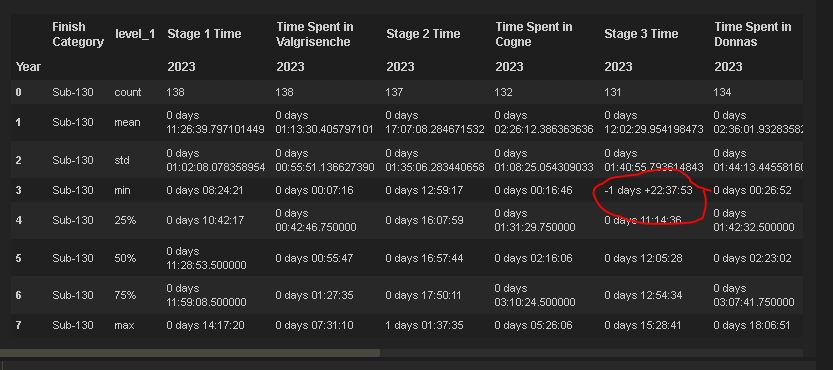

So I pulled the individual out to examine in more detail.

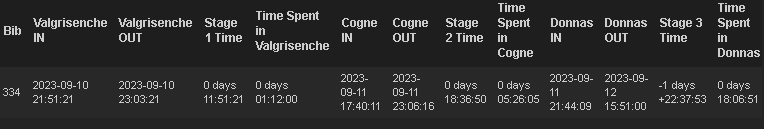

Looking at the raw data, it looks like it would make sense Bib# 334 to have been scanned 'DOnnas OUT' on the way in and 'Donnas IN' on the way out

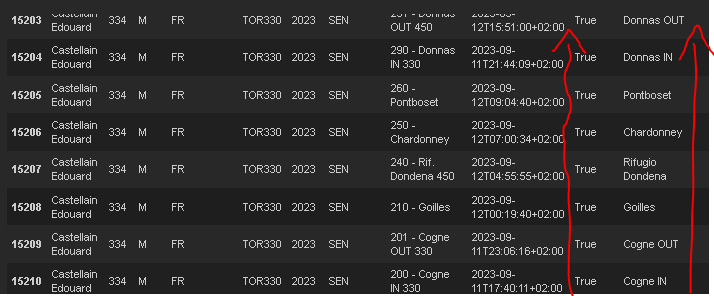

Code was written to detect more time travelling
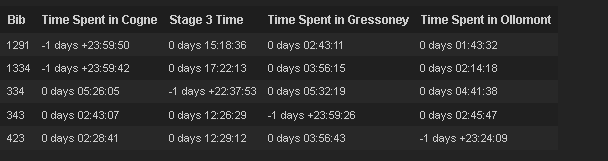


##### Time Travel issues in Checkpoint

In [84]:
unique_bibs_with_negative_values_in_checkpoints_bib_df = list(checkpoints_bib_df['Bib'][checkpoints_bib_df['Duration']  <= pd.to_timedelta('00:00:00')].unique())
unique_bibs_with_negative_values_in_checkpoints_bib_df = [int(bib) for bib in unique_bibs_with_negative_values_in_checkpoints_bib_df]

checkpoints_bib_df[checkpoints_bib_df['Duration']  <= pd.to_timedelta('00:00:00')]

,PK,Year,Race,Bib,Status,Status1,Retired,Wave,Checkpoint,Timestamp,...,Running Total Duration,Running Total Duration_seconds,Cut Off Date,Stage,Missed Last Checkpoint,Checkpoint Duration,Missed Lifebase Allocated Time,Missed,Missed Diff,Missed Diff_seconds
4495,TOR330_2024_404,2024,TOR330,404,True,Finished at Courmayeur,NaN,Wave1,Valtournenche OUT,2024-09-11 18:39:42,...,3 days 08:39:42,290382.0,2024-09-12 21:00:00,Time Spent in Valtournenche,False,0 days 02:00:00,Within Allocated Time,False,NaT,NaN
19466,TOR330_2024_1367,2024,TOR330,1367,False,DNF,Cogne,Wave2,Cogne OUT,2024-09-10 03:25:55,...,1 days 15:25:55,141955.0,2024-09-10 08:00:00,Time Spent in Cogne,False,0 days 02:00:00,Within Allocated Time,False,NaT,NaN


In [85]:
unique_bibs_with_negative_values_in_checkpoints_bib_df

[404, 1367]

In [86]:
fixing_negative_duration(checkpoints_bib_df)

checkpoints_bib_df[checkpoints_bib_df['Bib'].isin(unique_bibs_with_negative_values_in_checkpoints_bib_df)]

,PK,Year,Race,Bib,Status,Status1,Retired,Wave,Checkpoint,Timestamp,...,Running Total Duration,Running Total Duration_seconds,Cut Off Date,Stage,Missed Last Checkpoint,Checkpoint Duration,Missed Lifebase Allocated Time,Missed,Missed Diff,Missed Diff_seconds


In [87]:

checkpoints_bib_df =  calculating_banked_time(checkpoints_bib_df, checkpoints_cut_offs_df, 'Checkpoint')
checkpoints_bib_df.head(20)
checkpoints_bib_df[checkpoints_bib_df['Banking Time']  < pd.to_timedelta('00:00:00')] 

                                             20220            20221  \
Bib                                           1440             1440   
Checkpoint                                   Start        La Thuile   
Running Total Checkpoint Duration              NaT  0 days 05:30:00   
Running Total Duration             0 days 00:00:00  0 days 04:08:50   
Banking Time                                   NaT  0 days 01:21:10   

                                             20222             20223  \
Bib                                           1440              1440   
Checkpoint                         Valgrisenche IN  Valgrisenche OUT   
Running Total Checkpoint Duration  0 days 19:00:00   0 days 21:00:00   
Running Total Duration             0 days 15:31:45   0 days 19:05:55   
Banking Time                       0 days 03:28:15   0 days 01:54:05   

                                             20224  
Bib                                           1440  
Checkpoint                        

,PK,Year,Race,Bib,Status,Status1,Retired,Wave,Checkpoint,Timestamp,...,Stage,Missed Last Checkpoint,Checkpoint Duration,Missed Lifebase Allocated Time,Missed,Missed Diff,Missed Diff_seconds,Running Total Checkpoint Duration,Banking Time,Banking Time_seconds
7712,TOR330_2024_33,2024,TOR330,33,True,Finished at Courmayeur,NaN,Wave1,Gressoney OUT,2024-09-12 01:06:37,...,Time Spent in Gressoney,False,0 days 02:00:00,Outside Allocated Time,True,0 days 00:06:37,397.0,3 days 15:00:00,-1 days +23:53:23,-397.0
9538,TOR330_2024_544,2024,TOR330,544,True,Finished at Courmayeur,NaN,Wave1,Ollomont OUT,2024-09-13 19:07:06,...,Time Spent in Ollomont,False,0 days 02:00:00,Outside Allocated Time,True,0 days 00:07:06,426.0,5 days 09:00:00,-1 days +23:52:54,-426.0
9777,TOR330_2024_391,2024,TOR330,391,True,Finished at Courmayeur,NaN,Wave1,Ollomont IN,2024-09-13 17:00:23,...,Stage 6,False,0 days 05:00:00,Outside Allocated Time,True,0 days 00:00:23,23.0,5 days 07:00:00,-1 days +23:59:37,-23.0
9856,TOR330_2024_1280,2024,TOR330,1280,True,Finished at Courmayeur,NaN,Wave2,Oyace,2024-09-13 14:00:33,...,Stage 6,False,0 days 15:00:00,Outside Allocated Time,True,0 days 00:00:33,33.0,5 days 02:00:00,-1 days +23:59:27,-33.0
9932,TOR330_2024_500,2024,TOR330,500,True,Finished at Courmayeur,NaN,Wave1,Gressoney OUT,2024-09-12 01:00:18,...,Time Spent in Gressoney,False,0 days 02:00:00,Outside Allocated Time,True,0 days 00:00:18,18.0,3 days 15:00:00,-1 days +23:59:42,-18.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21257,TOR330_2024_1523,2024,TOR330,1523,False,DNF,Ollomont,Wave2,Ollomont IN,2024-09-13 19:45:59,...,Stage 6,True,0 days 05:00:00,Outside Allocated Time,True,0 days 00:45:59,2759.0,5 days 07:00:00,-1 days +23:14:01,-2759.0
21437,TOR330_2024_1538,2024,TOR330,1538,False,DNF,Ollomont,Wave2,Ollomont IN,2024-09-13 19:29:49,...,Stage 6,True,0 days 05:00:00,Outside Allocated Time,True,0 days 00:29:49,1789.0,5 days 07:00:00,-1 days +23:30:11,-1789.0
21511,TOR330_2024_1542,2024,TOR330,1542,False,DNF,Gressoney,Wave2,Gressoney IN,2024-09-12 01:41:28,...,Stage 4,True,0 days 03:30:00,Outside Allocated Time,True,0 days 00:41:28,2488.0,3 days 13:00:00,-1 days +23:18:32,-2488.0
21596,TOR330_2024_1548,2024,TOR330,1548,False,DNF,Oyace,Wave2,Oyace,2024-09-13 15:43:08,...,Stage 6,True,0 days 15:00:00,Outside Allocated Time,True,0 days 01:43:08,6188.0,5 days 02:00:00,-1 days +22:16:52,-6188.0


### Adding information related to the last missed cut off to TOR330 Dem

In [88]:
# Merge the datsets back after pivoting
TOR330_dem = TOR330_dem.merge(
    checkpoints_bib_df[[ 'Year', 'Race',  'Bib', 'Retired', 'Wave',
                        'Checkpoint', 'Missed Last Checkpoint',
                        'Missed Diff',  'Missed Diff_seconds' ]][(checkpoints_bib_df['Missed Last Checkpoint'] == True)],
    on=['Year', 'Race', 'Retired', 'Bib', 'Wave'],
    how='left')

TOR330_dem


,PK,Year,Race,Name,Bib,Sex,Nationality,Category,Status,Status1,Wave,Duration_seconds,Retired,Retired_Stage,Finish Category,Checkpoint,Missed Last Checkpoint,Missed Diff,Missed Diff_seconds
0,TOR330_2024_10,2024,TOR330,D Haene Francois,10,M,FR,SEN,True,Finished at Courmayeur,Wave1,248912.0,NaN,NaN,Sub-70,NaN,NaN,NaT,NaN
1,TOR330_2024_25,2024,TOR330,Marmissolle Benat,25,M,FR,V1,True,Finished at Courmayeur,Wave1,263418.0,NaN,NaN,Sub-80,NaN,NaN,NaT,NaN
2,TOR330_2024_7,2024,TOR330,Perrier Martin,7,M,CH,SEN,True,Finished at Courmayeur,Wave1,272159.0,NaN,NaN,Sub-80,NaN,NaN,NaT,NaN
3,TOR330_2024_20,2024,TOR330,Macchi Andrea,20,M,IT,SEN,True,Finished at Courmayeur,Wave1,276189.0,NaN,NaN,Sub-80,NaN,NaN,NaT,NaN
4,TOR330_2024_15,2024,TOR330,Hall Damian,15,M,GB,V1,True,Finished at Courmayeur,Wave1,276560.0,NaN,NaN,Sub-80,NaN,NaN,NaT,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1091,TOR330_2024_1568,2024,TOR330,Baik Myungki,1568,M,KR,V1,False,DNF,Wave2,NaN,Rhemes-Notre-Dame,Stage 2,DNF,NaN,NaN,NaT,NaN
1092,TOR330_2024_1569,2024,TOR330,Kim Juae,1569,F,KR,SEN,False,DNF,Wave2,NaN,Planaval,Stage 1,DNF,NaN,NaN,NaT,NaN
1093,TOR330_2024_1570,2024,TOR330,Choi Changhyu,1570,M,KR,V2,False,DNF,Wave2,NaN,Rhemes-Notre-Dame,Stage 2,DNF,NaN,NaN,NaT,NaN
1094,TOR330_2024_1573,2024,TOR330,Zhang Zhang Wenjun,1573,M,CN,V1,False,DNF,Wave2,NaN,Niel La Gruba,Stage 4,DNF,NaN,NaN,NaT,NaN


In [89]:
TOR330_dem.groupby('Retired')['Retired'].count()

Retired
Bivacco R. Clermont         1
Bosses                      4
Bruson Arp                  2
Chalet Epee                13
Champoluc                  14
Chardonney                  5
Cogne                      47
Col della Vecchia          10
Donnas                     19
Eaux Rousse                68
Goilles                     2
Gressoney                  53
La Thuile                  13
Lago Chiaro                 4
Loo                        12
Monte de la Saxe            1
Niel La Gruba              32
Ollomont                   18
Oyace                      25
Pas Entre Deux Sauts        1
Perloz                      3
Planaval                   12
Pontboset                   4
Ponteille Desot             2
Rhemes-Notre-Dame          40
Rifugio Alpenzu             7
Rifugio Barmasse            5
Rifugio Champillon          3
Rifugio Coda                7
Rifugio Cuney               1
Rifugio Deffeyes           12
Rifugio Dondena             3
Rifugio Frassati            3
Ri

In [90]:
checkpoints_bib_df.columns

Index(['PK', 'Year', 'Race', 'Bib', 'Status', 'Status1', 'Retired', 'Wave',
       'Checkpoint', 'Timestamp', 'Finish Category', 'Duration',
       'Duration_seconds', 'Running Total Duration',
       'Running Total Duration_seconds', 'Cut Off Date', 'Stage',
       'Missed Last Checkpoint', 'Checkpoint Duration',
       'Missed Lifebase Allocated Time', 'Missed', 'Missed Diff',
       'Missed Diff_seconds', 'Running Total Checkpoint Duration',
       'Banking Time', 'Banking Time_seconds'],
      dtype='object')

In [91]:
checkpoints_bib_df[checkpoints_bib_df['Missed Last Checkpoint'] == True].groupby(['Retired'])['Retired'].count()

Retired
Cogne                   8
Donnas                  1
Eaux Rousse             1
Gressoney              26
Niel La Gruba           5
Ollomont                4
Oyace                  12
Rifugio della Barma     8
Name: Retired, dtype: int64

#### Which Finishers missed the cut off?

In [92]:
checkpoints_bib_df[(checkpoints_bib_df['Missed'] == True) &
                  (checkpoints_bib_df['Retired'].isna())]

,PK,Year,Race,Bib,Status,Status1,Retired,Wave,Checkpoint,Timestamp,...,Stage,Missed Last Checkpoint,Checkpoint Duration,Missed Lifebase Allocated Time,Missed,Missed Diff,Missed Diff_seconds,Running Total Checkpoint Duration,Banking Time,Banking Time_seconds
7712,TOR330_2024_33,2024,TOR330,33,True,Finished at Courmayeur,NaN,Wave1,Gressoney OUT,2024-09-12 01:06:37,...,Time Spent in Gressoney,False,0 days 02:00:00,Outside Allocated Time,True,0 days 00:06:37,397.0,3 days 15:00:00,-1 days +23:53:23,-397.0
9538,TOR330_2024_544,2024,TOR330,544,True,Finished at Courmayeur,NaN,Wave1,Ollomont OUT,2024-09-13 19:07:06,...,Time Spent in Ollomont,False,0 days 02:00:00,Outside Allocated Time,True,0 days 00:07:06,426.0,5 days 09:00:00,-1 days +23:52:54,-426.0
9777,TOR330_2024_391,2024,TOR330,391,True,Finished at Courmayeur,NaN,Wave1,Ollomont IN,2024-09-13 17:00:23,...,Stage 6,False,0 days 05:00:00,Outside Allocated Time,True,0 days 00:00:23,23.0,5 days 07:00:00,-1 days +23:59:37,-23.0
9856,TOR330_2024_1280,2024,TOR330,1280,True,Finished at Courmayeur,NaN,Wave2,Oyace,2024-09-13 14:00:33,...,Stage 6,False,0 days 15:00:00,Outside Allocated Time,True,0 days 00:00:33,33.0,5 days 02:00:00,-1 days +23:59:27,-33.0
9932,TOR330_2024_500,2024,TOR330,500,True,Finished at Courmayeur,NaN,Wave1,Gressoney OUT,2024-09-12 01:00:18,...,Time Spent in Gressoney,False,0 days 02:00:00,Outside Allocated Time,True,0 days 00:00:18,18.0,3 days 15:00:00,-1 days +23:59:42,-18.0
10236,TOR330_2024_1566,2024,TOR330,1566,True,Finished at Courmayeur,NaN,Wave2,Oyace,2024-09-13 14:01:34,...,Stage 6,False,0 days 15:00:00,Outside Allocated Time,True,0 days 00:01:34,94.0,5 days 02:00:00,-1 days +23:58:26,-94.0
10258,TOR330_2024_1262,2024,TOR330,1262,True,Finished at Courmayeur,NaN,Wave2,Ollomont OUT,2024-09-13 21:03:24,...,Time Spent in Ollomont,False,0 days 02:00:00,Outside Allocated Time,True,0 days 00:03:24,204.0,5 days 09:00:00,-1 days +23:56:36,-204.0
10336,TOR330_2024_1525,2024,TOR330,1525,True,Finished at Courmayeur,NaN,Wave2,Oyace,2024-09-13 14:11:48,...,Stage 6,False,0 days 15:00:00,Outside Allocated Time,True,0 days 00:11:48,708.0,5 days 02:00:00,-1 days +23:48:12,-708.0
10506,TOR330_2024_506,2024,TOR330,506,True,Finished at Courmayeur,NaN,Wave1,Cogne OUT,2024-09-10 06:30:30,...,Time Spent in Cogne,False,0 days 02:00:00,Outside Allocated Time,True,0 days 00:30:30,1830.0,1 days 20:00:00,-1 days +23:29:30,-1830.0
10512,TOR330_2024_506,2024,TOR330,506,True,Finished at Courmayeur,NaN,Wave1,Gressoney OUT,2024-09-12 01:01:08,...,Time Spent in Gressoney,False,0 days 02:00:00,Outside Allocated Time,True,0 days 00:01:08,68.0,3 days 15:00:00,-1 days +23:58:52,-68.0


### Lifebase DF

In [93]:
lifebase_bib_df = checking_cut_offs(melt_lifebase_df, 'Lifebase', lifebase_cut_offs_df)
lifebase_bib_df.head()

1 Processing Bib: 10
2 Processing Bib: 25
3 Processing Bib: 7
4 Processing Bib: 20
5 Processing Bib: 15
6 Processing Bib: 13
7 Processing Bib: 6
8 Processing Bib: 597
9 Processing Bib: 2
10 Processing Bib: 336
11 Processing Bib: 18
12 Processing Bib: 532
13 Processing Bib: 183
14 Processing Bib: 522
15 Processing Bib: 282
16 Processing Bib: 399
17 Processing Bib: 4
18 Processing Bib: 1511
19 Processing Bib: 24
20 Processing Bib: 227
21 Processing Bib: 606
22 Processing Bib: 169
23 Processing Bib: 580
24 Processing Bib: 538
25 Processing Bib: 428
26 Processing Bib: 368
27 Processing Bib: 469
28 Processing Bib: 477
29 Processing Bib: 589
30 Processing Bib: 373
31 Processing Bib: 452
32 Processing Bib: 453
33 Processing Bib: 157
34 Processing Bib: 114
35 Processing Bib: 83
36 Processing Bib: 243
37 Processing Bib: 556
38 Processing Bib: 258
39 Processing Bib: 545
40 Processing Bib: 594
41 Processing Bib: 277
42 Processing Bib: 253
43 Processing Bib: 479
44 Processing Bib: 502
45 Processin

352 Processing Bib: 85
353 Processing Bib: 1167
354 Processing Bib: 176
355 Processing Bib: 1217
356 Processing Bib: 1227
357 Processing Bib: 419
358 Processing Bib: 1236
359 Processing Bib: 1350
360 Processing Bib: 1102
361 Processing Bib: 1170
362 Processing Bib: 1425
363 Processing Bib: 638
364 Processing Bib: 1090
365 Processing Bib: 364
366 Processing Bib: 66
367 Processing Bib: 1012
368 Processing Bib: 53
369 Processing Bib: 276
370 Processing Bib: 40
371 Processing Bib: 321
372 Processing Bib: 1329
373 Processing Bib: 1237
374 Processing Bib: 1215
375 Processing Bib: 1426
376 Processing Bib: 96
377 Processing Bib: 194
378 Processing Bib: 1029
379 Processing Bib: 579
380 Processing Bib: 1232
381 Processing Bib: 1089
382 Processing Bib: 369
383 Processing Bib: 370
384 Processing Bib: 636
385 Processing Bib: 389
386 Processing Bib: 33
387 Processing Bib: 1024
388 Processing Bib: 1246
389 Processing Bib: 341
390 Processing Bib: 303
391 Processing Bib: 1544
392 Processing Bib: 271
39

697 Processing Bib: 463
698 Processing Bib: 470
699 Processing Bib: 472
700 Processing Bib: 485
701 Processing Bib: 486
702 Processing Bib: 488
703 Processing Bib: 489
704 Processing Bib: 492
705 Processing Bib: 496
706 Processing Bib: 501
707 Processing Bib: 504
708 Processing Bib: 505
709 Processing Bib: 509
710 Processing Bib: 510
711 Processing Bib: 514
712 Processing Bib: 515
713 Processing Bib: 516
714 Processing Bib: 517
715 Processing Bib: 525
716 Processing Bib: 528
717 Processing Bib: 530
718 Processing Bib: 535
719 Processing Bib: 539
720 Processing Bib: 542
721 Processing Bib: 547
722 Processing Bib: 549
723 Processing Bib: 550
724 Processing Bib: 557
725 Processing Bib: 560
3 4
726 Processing Bib: 561
727 Processing Bib: 563
728 Processing Bib: 566
729 Processing Bib: 568
730 Processing Bib: 570
731 Processing Bib: 571
732 Processing Bib: 572
733 Processing Bib: 583
734 Processing Bib: 584
735 Processing Bib: 585
736 Processing Bib: 590
737 Processing Bib: 592
738 Processi

1024 Processing Bib: 1462
1025 Processing Bib: 1463
1026 Processing Bib: 1464
1027 Processing Bib: 1465
1028 Processing Bib: 1466
1029 Processing Bib: 1467
1030 Processing Bib: 1471
7 8
1031 Processing Bib: 1473
1032 Processing Bib: 1474
1033 Processing Bib: 1475
1034 Processing Bib: 1476
1035 Processing Bib: 1478
1036 Processing Bib: 1479
1037 Processing Bib: 1481
1038 Processing Bib: 1482
1039 Processing Bib: 1483
1040 Processing Bib: 1484
7 8
1041 Processing Bib: 1485
1042 Processing Bib: 1489
1043 Processing Bib: 1490
3 4
1044 Processing Bib: 1492
1045 Processing Bib: 1493
1046 Processing Bib: 1494
1047 Processing Bib: 1495
1048 Processing Bib: 1497
1049 Processing Bib: 1498
1050 Processing Bib: 1499
1051 Processing Bib: 1501
1052 Processing Bib: 1504
1053 Processing Bib: 1506
1054 Processing Bib: 1507
1055 Processing Bib: 1508
1056 Processing Bib: 1510
1057 Processing Bib: 1512
1058 Processing Bib: 1514
1059 Processing Bib: 1515
11 12
1060 Processing Bib: 1516
1061 Processing Bib:

,PK,Year,Race,Bib,Status,Status1,Retired,Wave,Lifebase,Timestamp,...,Running Total Duration,Running Total Duration_seconds,Cut Off Date,Stage,Missed Last Checkpoint,Lifebase Duration,Missed Lifebase Allocated Time,Missed,Missed Diff,Missed Diff_seconds
0,TOR330_2024_10,2024,TOR330,10,True,Finished at Courmayeur,NaN,Wave1,Start,2024-09-08 10:00:00,...,0 days 00:00:00,0.0,2024-09-08 10:00:00,Stage 1,False,NaT,Within Allocated Time,False,NaT,NaN
1,TOR330_2024_10,2024,TOR330,10,True,Finished at Courmayeur,NaN,Wave1,Valgrisenche IN,2024-09-08 17:04:36,...,0 days 07:04:36,25476.0,2024-09-09 05:00:00,Stage 1,False,0 days 19:00:00,Within Allocated Time,False,NaT,NaN
2,TOR330_2024_10,2024,TOR330,10,True,Finished at Courmayeur,NaN,Wave1,Valgrisenche OUT,2024-09-08 17:05:13,...,0 days 07:05:13,25513.0,2024-09-09 07:00:00,Time Spent in Valgrisenche,False,0 days 02:00:00,Within Allocated Time,False,NaT,NaN
3,TOR330_2024_10,2024,TOR330,10,True,Finished at Courmayeur,NaN,Wave1,Cogne IN,2024-09-09 02:44:15,...,0 days 16:44:15,60255.0,2024-09-10 04:00:00,Stage 2,False,0 days 21:00:00,Within Allocated Time,False,NaT,NaN
4,TOR330_2024_10,2024,TOR330,10,True,Finished at Courmayeur,NaN,Wave1,Cogne OUT,2024-09-09 02:45:30,...,0 days 16:45:30,60330.0,2024-09-10 06:00:00,Time Spent in Cogne,False,0 days 02:00:00,Within Allocated Time,False,NaT,NaN


##### Time Travel issues in Lifebase DF 

In [94]:
unique_bibs_with_negative_values_in_lifebase_bib_df = list(lifebase_bib_df['Bib'][lifebase_bib_df['Duration']  <= pd.to_timedelta('00:00:00')].unique())
unique_bibs_with_negative_values_in_lifebase_bib_df = [int(bib) for bib in unique_bibs_with_negative_values_in_lifebase_bib_df]

lifebase_bib_df[lifebase_bib_df['Duration']  <= pd.to_timedelta('00:00:00')]

,PK,Year,Race,Bib,Status,Status1,Retired,Wave,Lifebase,Timestamp,...,Running Total Duration,Running Total Duration_seconds,Cut Off Date,Stage,Missed Last Checkpoint,Lifebase Duration,Missed Lifebase Allocated Time,Missed,Missed Diff,Missed Diff_seconds
3146,TOR330_2024_404,2024,TOR330,404,True,Finished at Courmayeur,NaN,Wave1,Valtournenche OUT,2024-09-11 18:39:42,...,3 days 08:39:42,290382.0,2024-09-12 21:00:00,Time Spent in Valtournenche,False,0 days 02:00:00,Within Allocated Time,False,NaT,NaN
13626,TOR330_2024_1367,2024,TOR330,1367,False,DNF,Cogne,Wave2,Cogne OUT,2024-09-10 03:25:55,...,1 days 15:25:55,141955.0,2024-09-10 08:00:00,Time Spent in Cogne,False,0 days 02:00:00,Within Allocated Time,False,NaT,NaN


In [95]:
fixing_negative_duration(lifebase_bib_df)

lifebase_bib_df[(lifebase_bib_df['Bib'].isin(unique_bibs_with_negative_values_in_lifebase_bib_df ))]

,PK,Year,Race,Bib,Status,Status1,Retired,Wave,Lifebase,Timestamp,...,Running Total Duration,Running Total Duration_seconds,Cut Off Date,Stage,Missed Last Checkpoint,Lifebase Duration,Missed Lifebase Allocated Time,Missed,Missed Diff,Missed Diff_seconds


In [96]:
lifebase_bib_df = calculating_banked_time(lifebase_bib_df, lifebase_cut_offs_df, 'Lifebase')
lifebase_bib_df.head(20)
lifebase_bib_df[lifebase_bib_df['Banking Time']  < pd.to_timedelta('00:00:00')] 


                                           14154            14155  \
Bib                                         1440             1440   
Lifebase                                   Start  Valgrisenche IN   
Running Total Lifebase Duration              NaT  0 days 19:00:00   
Running Total Duration           0 days 00:00:00  0 days 15:31:45   
Banking Time                                 NaT  0 days 03:28:15   

                                            14156            14157  \
Bib                                          1440             1440   
Lifebase                         Valgrisenche OUT         Cogne IN   
Running Total Lifebase Duration   0 days 21:00:00  1 days 18:00:00   
Running Total Duration            0 days 19:05:55              NaT   
Banking Time                      0 days 01:54:05              NaT   

                                           14158  
Bib                                         1440  
Lifebase                               Cogne OUT  
Running Tot

,PK,Year,Race,Bib,Status,Status1,Retired,Wave,Lifebase,Timestamp,...,Stage,Missed Last Checkpoint,Lifebase Duration,Missed Lifebase Allocated Time,Missed,Missed Diff,Missed Diff_seconds,Running Total Lifebase Duration,Banking Time,Banking Time_seconds
5398,TOR330_2024_33,2024,TOR330,33,True,Finished at Courmayeur,NaN,Wave1,Gressoney OUT,2024-09-12 01:06:37,...,Time Spent in Gressoney,False,0 days 02:00:00,Outside Allocated Time,True,0 days 00:06:37,397.0,3 days 15:00:00,-1 days +23:53:23,-397.0
6676,TOR330_2024_544,2024,TOR330,544,True,Finished at Courmayeur,NaN,Wave1,Ollomont OUT,2024-09-13 19:07:06,...,Time Spent in Ollomont,False,0 days 02:00:00,Outside Allocated Time,True,0 days 00:07:06,426.0,5 days 09:00:00,-1 days +23:52:54,-426.0
6843,TOR330_2024_391,2024,TOR330,391,True,Finished at Courmayeur,NaN,Wave1,Ollomont IN,2024-09-13 17:00:23,...,Stage 6,False,0 days 20:00:00,Outside Allocated Time,True,0 days 00:00:23,23.0,5 days 07:00:00,-1 days +23:59:37,-23.0
6952,TOR330_2024_500,2024,TOR330,500,True,Finished at Courmayeur,NaN,Wave1,Gressoney OUT,2024-09-12 01:00:18,...,Time Spent in Gressoney,False,0 days 02:00:00,Outside Allocated Time,True,0 days 00:00:18,18.0,3 days 15:00:00,-1 days +23:59:42,-18.0
7180,TOR330_2024_1262,2024,TOR330,1262,True,Finished at Courmayeur,NaN,Wave2,Ollomont OUT,2024-09-13 21:03:24,...,Time Spent in Ollomont,False,0 days 02:00:00,Outside Allocated Time,True,0 days 00:03:24,204.0,5 days 09:00:00,-1 days +23:56:36,-204.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14823,TOR330_2024_1515,2024,TOR330,1515,False,DNF,Ollomont,Wave2,Ollomont IN,2024-09-13 19:46:05,...,Stage 6,True,0 days 20:00:00,Outside Allocated Time,True,0 days 00:46:05,2765.0,5 days 07:00:00,-1 days +23:13:55,-2765.0
14879,TOR330_2024_1523,2024,TOR330,1523,False,DNF,Ollomont,Wave2,Ollomont IN,2024-09-13 19:45:59,...,Stage 6,True,0 days 20:00:00,Outside Allocated Time,True,0 days 00:45:59,2759.0,5 days 07:00:00,-1 days +23:14:01,-2759.0
15005,TOR330_2024_1538,2024,TOR330,1538,False,DNF,Ollomont,Wave2,Ollomont IN,2024-09-13 19:29:49,...,Stage 6,True,0 days 20:00:00,Outside Allocated Time,True,0 days 00:29:49,1789.0,5 days 07:00:00,-1 days +23:30:11,-1789.0
15057,TOR330_2024_1542,2024,TOR330,1542,False,DNF,Gressoney,Wave2,Gressoney IN,2024-09-12 01:41:28,...,Stage 4,True,0 days 21:00:00,Outside Allocated Time,True,0 days 00:41:28,2488.0,3 days 13:00:00,-1 days +23:18:32,-2488.0


### Aid Station DF

In [97]:
all_aid_station_bib_df = checking_cut_offs(melt_TOR330, 'Aid Station', aid_station_cut_offs_df)

1 Processing Bib: 10
2 Processing Bib: 25
3 Processing Bib: 7
4 Processing Bib: 20
5 Processing Bib: 15
6 Processing Bib: 13
7 Processing Bib: 6
8 Processing Bib: 597
9 Processing Bib: 2
10 Processing Bib: 336
11 Processing Bib: 18
12 Processing Bib: 532
13 Processing Bib: 183
14 Processing Bib: 522
15 Processing Bib: 282
16 Processing Bib: 399
17 Processing Bib: 4
18 Processing Bib: 1511
19 Processing Bib: 24
20 Processing Bib: 227
21 Processing Bib: 606
22 Processing Bib: 169
23 Processing Bib: 580
24 Processing Bib: 538
25 Processing Bib: 428
26 Processing Bib: 368
27 Processing Bib: 469
28 Processing Bib: 477
29 Processing Bib: 589
30 Processing Bib: 373
31 Processing Bib: 452
32 Processing Bib: 453
33 Processing Bib: 157
34 Processing Bib: 114
35 Processing Bib: 83
36 Processing Bib: 243
37 Processing Bib: 556
38 Processing Bib: 258
39 Processing Bib: 545
40 Processing Bib: 594
41 Processing Bib: 277
42 Processing Bib: 253
43 Processing Bib: 479
44 Processing Bib: 502
45 Processin

349 Processing Bib: 1526
350 Processing Bib: 1340
351 Processing Bib: 1226
352 Processing Bib: 85
353 Processing Bib: 1167
354 Processing Bib: 176
355 Processing Bib: 1217
356 Processing Bib: 1227
357 Processing Bib: 419
358 Processing Bib: 1236
359 Processing Bib: 1350
360 Processing Bib: 1102
361 Processing Bib: 1170
362 Processing Bib: 1425
363 Processing Bib: 638
364 Processing Bib: 1090
365 Processing Bib: 364
366 Processing Bib: 66
367 Processing Bib: 1012
368 Processing Bib: 53
369 Processing Bib: 276
370 Processing Bib: 40
371 Processing Bib: 321
372 Processing Bib: 1329
373 Processing Bib: 1237
374 Processing Bib: 1215
375 Processing Bib: 1426
376 Processing Bib: 96
377 Processing Bib: 194
378 Processing Bib: 1029
379 Processing Bib: 579
380 Processing Bib: 1232
381 Processing Bib: 1089
382 Processing Bib: 369
383 Processing Bib: 370
384 Processing Bib: 636
385 Processing Bib: 389
386 Processing Bib: 33
387 Processing Bib: 1024
388 Processing Bib: 1246
389 Processing Bib: 341


690 Processing Bib: 447
691 Processing Bib: 450
692 Processing Bib: 455
693 Processing Bib: 456
694 Processing Bib: 457
695 Processing Bib: 458
696 Processing Bib: 462
697 Processing Bib: 463
698 Processing Bib: 470
699 Processing Bib: 472
700 Processing Bib: 485
701 Processing Bib: 486
702 Processing Bib: 488
703 Processing Bib: 489
704 Processing Bib: 492
705 Processing Bib: 496
706 Processing Bib: 501
707 Processing Bib: 504
708 Processing Bib: 505
709 Processing Bib: 509
710 Processing Bib: 510
711 Processing Bib: 514
712 Processing Bib: 515
713 Processing Bib: 516
714 Processing Bib: 517
715 Processing Bib: 525
716 Processing Bib: 528
717 Processing Bib: 530
718 Processing Bib: 535
719 Processing Bib: 539
720 Processing Bib: 542
721 Processing Bib: 547
722 Processing Bib: 549
723 Processing Bib: 550
724 Processing Bib: 557
725 Processing Bib: 560
11 12
726 Processing Bib: 561
727 Processing Bib: 563
728 Processing Bib: 566
729 Processing Bib: 568
730 Processing Bib: 570
731 Proces

1018 Processing Bib: 1450
1019 Processing Bib: 1451
1020 Processing Bib: 1453
1021 Processing Bib: 1454
1022 Processing Bib: 1458
1023 Processing Bib: 1460
1024 Processing Bib: 1462
1025 Processing Bib: 1463
1026 Processing Bib: 1464
1027 Processing Bib: 1465
1028 Processing Bib: 1466
1029 Processing Bib: 1467
1030 Processing Bib: 1471
27 28
1031 Processing Bib: 1473
1032 Processing Bib: 1474
1033 Processing Bib: 1475
1034 Processing Bib: 1476
1035 Processing Bib: 1478
1036 Processing Bib: 1479
1037 Processing Bib: 1481
1038 Processing Bib: 1482
1039 Processing Bib: 1483
1040 Processing Bib: 1484
27 28
1041 Processing Bib: 1485
1042 Processing Bib: 1489
1043 Processing Bib: 1490
11 12
1044 Processing Bib: 1492
1045 Processing Bib: 1493
1046 Processing Bib: 1494
1047 Processing Bib: 1495
1048 Processing Bib: 1497
1049 Processing Bib: 1498
1050 Processing Bib: 1499
1051 Processing Bib: 1501
1052 Processing Bib: 1504
1053 Processing Bib: 1506
1054 Processing Bib: 1507
1055 Processing Bib:

C:\Users\Karina\AppData\Local\Temp\ipykernel_21692\3084598682.py:204: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['Missed Last Checkpoint'][~(final_df['Missed Diff'].isna()) &


##### Time Travel issues in Aid Station 

In [98]:
unique_bibs_with_negative_values_in_all_aid_station_bib_df = list(all_aid_station_bib_df['Bib'][all_aid_station_bib_df['Duration']  <= pd.to_timedelta('00:00:00')].unique())
unique_bibs_with_negative_values_in_lifebase_bib_df = [int(bib) for bib in unique_bibs_with_negative_values_in_all_aid_station_bib_df]

all_aid_station_bib_df[all_aid_station_bib_df['Duration']  <= pd.to_timedelta('00:00:00')]

,PK,Year,Race,Bib,Status,Status1,Retired,Wave,Aid Station,Timestamp,...,Running Total Duration,Running Total Duration_seconds,Cut Off Date,Stage,Checkpoint Duration,Missed Lifebase Allocated Time,Missed Last Checkpoint,Missed,Missed Diff,Missed Diff_seconds
11233,TOR330_2024_404,2024,TOR330,404,True,Finished at Courmayeur,NaN,Wave1,Valtournenche OUT,2024-09-11 18:39:42,...,3 days 08:39:42,290382.0,2024-09-12 21:00:00,Time Spent in Valtournenche,0 days 02:00:00,Within Allocated Time,False,False,NaT,NaN
13448,TOR330_2024_1384,2024,TOR330,1384,True,Finished at Courmayeur,NaN,Wave2,Monte de la Saxe,2024-09-14 00:01:06,...,5 days 12:01:06,475266.0,NaT,NaN,NaT,Within Allocated Time,False,False,NaT,NaN
14148,TOR330_2024_593,2024,TOR330,593,True,Finished at Courmayeur,NaN,Wave1,Monte de la Saxe,2024-09-13 23:35:30,...,5 days 13:35:30,480930.0,NaT,NaN,NaT,Within Allocated Time,False,False,NaT,NaN
14598,TOR330_2024_405,2024,TOR330,405,True,Finished at Courmayeur,NaN,Wave1,Monte de la Saxe,2024-09-14 00:01:19,...,5 days 14:01:19,482479.0,NaT,NaN,NaT,Within Allocated Time,False,False,NaT,NaN
14648,TOR330_2024_223,2024,TOR330,223,True,Finished at Courmayeur,NaN,Wave1,Monte de la Saxe,2024-09-14 00:02:46,...,5 days 14:02:46,482566.0,NaT,NaN,NaT,Within Allocated Time,False,False,NaT,NaN
14698,TOR330_2024_567,2024,TOR330,567,True,Finished at Courmayeur,NaN,Wave1,Monte de la Saxe,2024-09-13 23:55:11,...,5 days 13:55:11,482111.0,NaT,NaN,NaT,Within Allocated Time,False,False,NaT,NaN
20893,TOR330_2024_38,2024,TOR330,38,True,Finished at Courmayeur,NaN,Wave1,Rifugio Champillon,2024-09-12 20:41:59,...,4 days 10:41:59,384119.0,NaT,NaN,NaT,Within Allocated Time,False,False,NaT,NaN
24190,TOR330_2024_431,2024,TOR330,431,True,Finished at Courmayeur,NaN,Wave1,Bruson Arp,2024-09-12 16:15:24,...,4 days 06:15:24,368124.0,NaT,NaN,NaT,Within Allocated Time,False,False,NaT,NaN
24193,TOR330_2024_431,2024,TOR330,431,True,Finished at Courmayeur,NaN,Wave1,Rifugio Champillon,2024-09-12 21:20:49,...,4 days 11:20:49,386449.0,NaT,NaN,NaT,Within Allocated Time,False,False,NaT,NaN
48662,TOR330_2024_1367,2024,TOR330,1367,False,DNF,Cogne,Wave2,Cogne OUT,2024-09-10 03:25:55,...,1 days 15:25:55,141955.0,2024-09-10 08:00:00,Time Spent in Cogne,0 days 02:00:00,Within Allocated Time,False,False,NaT,NaN


##### Saving Time Travel Issues

In [99]:
time_travel_issue = []

# Find rows with negative time values in the current stage
negative = all_aid_station_bib_df[all_aid_station_bib_df['Duration']  <= pd.to_timedelta('00:00:00')]
print(negative)

# Save the result to a file 
saving_tableau_df(negative, 'time_travel_issues_df')

                     PK  Year    Race   Bib  Status                 Status1  \
11233   TOR330_2024_404  2024  TOR330   404    True  Finished at Courmayeur   
13448  TOR330_2024_1384  2024  TOR330  1384    True  Finished at Courmayeur   
14148   TOR330_2024_593  2024  TOR330   593    True  Finished at Courmayeur   
14598   TOR330_2024_405  2024  TOR330   405    True  Finished at Courmayeur   
14648   TOR330_2024_223  2024  TOR330   223    True  Finished at Courmayeur   
14698   TOR330_2024_567  2024  TOR330   567    True  Finished at Courmayeur   
20893    TOR330_2024_38  2024  TOR330    38    True  Finished at Courmayeur   
24190   TOR330_2024_431  2024  TOR330   431    True  Finished at Courmayeur   
24193   TOR330_2024_431  2024  TOR330   431    True  Finished at Courmayeur   
48662  TOR330_2024_1367  2024  TOR330  1367   False                     DNF   

      Retired   Wave         Aid Station           Timestamp  ...  \
11233     NaN  Wave1   Valtournenche OUT 2024-09-11 18:39:42 

C:\Users\Karina\AppData\Local\Temp\ipykernel_21692\740375981.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[num_column] = df[num_column].astype('int')
C:\Users\Karina\AppData\Local\Temp\ipykernel_21692\740375981.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[num_column] = df[num_column].astype('str')


New rows added to the file.


In [100]:
fixing_negative_duration(all_aid_station_bib_df)

all_aid_station_bib_df[(all_aid_station_bib_df['Bib'].isin(unique_bibs_with_negative_values_in_all_aid_station_bib_df ))]

,PK,Year,Race,Bib,Status,Status1,Retired,Wave,Aid Station,Timestamp,...,Running Total Duration,Running Total Duration_seconds,Cut Off Date,Stage,Checkpoint Duration,Missed Lifebase Allocated Time,Missed Last Checkpoint,Missed,Missed Diff,Missed Diff_seconds
11200,TOR330_2024_404,2024,TOR330,404,True,Finished at Courmayeur,NaN,Wave1,Start,2024-09-08 10:00:00,...,0 days 00:00:00,0.0,2024-09-08 10:00:00,Stage 1,NaT,Within Allocated Time,False,False,NaT,NaN
11201,TOR330_2024_404,2024,TOR330,404,True,Finished at Courmayeur,NaN,Wave1,Baite Youlaz,2024-09-08 12:22:37,...,0 days 02:22:37,8557.0,NaT,NaN,NaT,Within Allocated Time,False,False,NaT,NaN
11202,TOR330_2024_404,2024,TOR330,404,True,Finished at Courmayeur,NaN,Wave1,La Thuile,2024-09-08 13:04:34,...,0 days 03:04:34,11074.0,2024-09-08 15:30:00,Stage 1,0 days 05:30:00,Within Allocated Time,False,False,NaT,NaN
11203,TOR330_2024_404,2024,TOR330,404,True,Finished at Courmayeur,NaN,Wave1,Rifugio Deffeyes,2024-09-08 15:03:07,...,0 days 05:03:07,18187.0,NaT,NaN,NaT,Within Allocated Time,False,False,NaT,NaN
11204,TOR330_2024_404,2024,TOR330,404,True,Finished at Courmayeur,NaN,Wave1,Planaval,2024-09-08 18:35:09,...,0 days 08:35:09,30909.0,NaT,NaN,NaT,Within Allocated Time,False,False,NaT,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48695,TOR330_2024_1367,2024,TOR330,1367,False,DNF,Cogne,Wave2,Bosses,NaT,...,NaT,NaN,NaT,NaN,NaT,Within Allocated Time,False,False,NaT,NaN
48696,TOR330_2024_1367,2024,TOR330,1367,False,DNF,Cogne,Wave2,Rifugio Frassati,NaT,...,NaT,NaN,NaT,NaN,NaT,Within Allocated Time,False,False,NaT,NaN
48697,TOR330_2024_1367,2024,TOR330,1367,False,DNF,Cogne,Wave2,Pas Entre Deux Sauts,NaT,...,NaT,NaN,NaT,NaN,NaT,Within Allocated Time,False,False,NaT,NaN
48698,TOR330_2024_1367,2024,TOR330,1367,False,DNF,Cogne,Wave2,Monte de la Saxe,NaT,...,NaT,NaN,NaT,NaN,NaT,Within Allocated Time,False,False,NaT,NaN


In [101]:
all_aid_station_bib_df[all_aid_station_bib_df['Bib'] == 1440]

,PK,Year,Race,Bib,Status,Status1,Retired,Wave,Aid Station,Timestamp,...,Running Total Duration,Running Total Duration_seconds,Cut Off Date,Stage,Checkpoint Duration,Missed Lifebase Allocated Time,Missed Last Checkpoint,Missed,Missed Diff,Missed Diff_seconds


### Saving All Dataframes

In [102]:
TOR330_dem['Missed Last Checkpoint'] = TOR330_dem['Missed Last Checkpoint'].fillna('False')
TOR330_dem['Missed Last Checkpoint'] = TOR330_dem['Missed Last Checkpoint'].astype('str')
TOR330_dem['Missed Last Checkpoint'].unique()

array(['False', 'True'], dtype=object)

In [103]:
TOR330_dem['Status'] = TOR330_dem['Status'].astype('str')
TOR330_dem['Status'].unique()

array(['True', 'False'], dtype=object)

In [104]:
TOR330_dem[TOR330_dem['Bib'] == 1440]

,PK,Year,Race,Name,Bib,Sex,Nationality,Category,Status,Status1,Wave,Duration_seconds,Retired,Retired_Stage,Finish Category,Checkpoint,Missed Last Checkpoint,Missed Diff,Missed Diff_seconds


##### Demographics

In [105]:
saving_tableau_df(TOR330_dem, 'dem')

New rows added to the file.


##### Checkpoint

In [106]:
checkpoint_dem_list = ['PK', 'Year', 'Race', 'Bib', 'Wave', 
                       'Checkpoint', 'Stage', 'Timestamp',
                       'Duration_seconds', 'Running Total Duration_seconds', 'Banking Time_seconds',\
                       'Missed Lifebase Allocated Time']


checkpoints_bib_df[checkpoint_dem_list][(checkpoints_bib_df['Bib'] == '1440')]

,PK,Year,Race,Bib,Wave,Checkpoint,Stage,Timestamp,Duration_seconds,Running Total Duration_seconds,Banking Time_seconds,Missed Lifebase Allocated Time
20220,TOR330_2024_1440,2024,TOR330,1440,Wave2,Start,Stage 1,2024-09-08 12:00:00,NaN,0.0,NaN,Within Allocated Time
20221,TOR330_2024_1440,2024,TOR330,1440,Wave2,La Thuile,Stage 1,2024-09-08 16:08:50,14930.0,14930.0,4870.0,Within Allocated Time
20222,TOR330_2024_1440,2024,TOR330,1440,Wave2,Valgrisenche IN,Stage 1,2024-09-09 03:31:45,40975.0,55905.0,12495.0,Within Allocated Time
20223,TOR330_2024_1440,2024,TOR330,1440,Wave2,Valgrisenche OUT,Time Spent in Valgrisenche,2024-09-09 07:05:55,12850.0,68755.0,6845.0,Outside Allocated Time
20224,TOR330_2024_1440,2024,TOR330,1440,Wave2,Eaux Rousse,Stage 2,NaT,NaN,NaN,NaN,Within Allocated Time
20225,TOR330_2024_1440,2024,TOR330,1440,Wave2,Cogne IN,Stage 2,NaT,NaN,NaN,NaN,Within Allocated Time
20226,TOR330_2024_1440,2024,TOR330,1440,Wave2,Cogne OUT,Time Spent in Cogne,NaT,NaN,NaN,NaN,Within Allocated Time
20227,TOR330_2024_1440,2024,TOR330,1440,Wave2,Donnas IN,Stage 3,NaT,NaN,NaN,NaN,Within Allocated Time
20228,TOR330_2024_1440,2024,TOR330,1440,Wave2,Donnas OUT,Time Spent in Donnas,NaT,NaN,NaN,NaN,Within Allocated Time
20229,TOR330_2024_1440,2024,TOR330,1440,Wave2,Rifugio della Barma,Stage 4,NaT,NaN,NaN,NaN,Within Allocated Time


In [107]:
saving_tableau_df(checkpoints_bib_df[checkpoint_dem_list], 'checkpoints_bib_df')

C:\Users\Karina\AppData\Local\Temp\ipykernel_21692\740375981.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[num_column] = df[num_column].astype('int')
C:\Users\Karina\AppData\Local\Temp\ipykernel_21692\740375981.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[num_column] = df[num_column].astype('str')


New rows added to the file.


##### Lifebase

In [108]:
lifebase_dem_list = ['PK', 'Year', 'Race', 'Bib', 'Wave', 
                     'Lifebase', 'Stage','Timestamp',  'Duration_seconds',
                     'Running Total Duration_seconds', 'Banking Time_seconds',\
                       'Missed Lifebase Allocated Time']


lifebase_bib_df[lifebase_dem_list][(lifebase_bib_df['Bib'] == '1440')]

,PK,Year,Race,Bib,Wave,Lifebase,Stage,Timestamp,Duration_seconds,Running Total Duration_seconds,Banking Time_seconds,Missed Lifebase Allocated Time
14154,TOR330_2024_1440,2024,TOR330,1440,Wave2,Start,Stage 1,2024-09-08 12:00:00,NaN,0.0,NaN,Within Allocated Time
14155,TOR330_2024_1440,2024,TOR330,1440,Wave2,Valgrisenche IN,Stage 1,2024-09-09 03:31:45,55905.0,55905.0,12495.0,Within Allocated Time
14156,TOR330_2024_1440,2024,TOR330,1440,Wave2,Valgrisenche OUT,Time Spent in Valgrisenche,2024-09-09 07:05:55,12850.0,68755.0,6845.0,Outside Allocated Time
14157,TOR330_2024_1440,2024,TOR330,1440,Wave2,Cogne IN,Stage 2,NaT,NaN,NaN,NaN,Within Allocated Time
14158,TOR330_2024_1440,2024,TOR330,1440,Wave2,Cogne OUT,Time Spent in Cogne,NaT,NaN,NaN,NaN,Within Allocated Time
14159,TOR330_2024_1440,2024,TOR330,1440,Wave2,Donnas IN,Stage 3,NaT,NaN,NaN,NaN,Within Allocated Time
14160,TOR330_2024_1440,2024,TOR330,1440,Wave2,Donnas OUT,Time Spent in Donnas,NaT,NaN,NaN,NaN,Within Allocated Time
14161,TOR330_2024_1440,2024,TOR330,1440,Wave2,Gressoney IN,Stage 4,NaT,NaN,NaN,NaN,Within Allocated Time
14162,TOR330_2024_1440,2024,TOR330,1440,Wave2,Gressoney OUT,Time Spent in Gressoney,NaT,NaN,NaN,NaN,Within Allocated Time
14163,TOR330_2024_1440,2024,TOR330,1440,Wave2,Valtournenche IN,Stage 5,NaT,NaN,NaN,NaN,Within Allocated Time


In [109]:
saving_tableau_df(lifebase_bib_df[lifebase_dem_list], 'lifebase_bib_df')

C:\Users\Karina\AppData\Local\Temp\ipykernel_21692\740375981.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[num_column] = df[num_column].astype('int')
C:\Users\Karina\AppData\Local\Temp\ipykernel_21692\740375981.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[num_column] = df[num_column].astype('str')


New rows added to the file.


##### Aid Station

In [110]:

for stage,  stage_str in zip(stages, stages_str):
    all_aid_station_bib_df.loc[all_aid_station_bib_df['Aid Station'].isin(stage), 'Stage'] = f'{stage_str}'


In [111]:
aid_station_dem_list = ['PK', 'Year', 'Race', 'Bib', 'Wave', \
                        'Aid Station', 'Stage', 'Timestamp',  \
                        'Duration_seconds', 'Running Total Duration_seconds',\
                       'Missed Lifebase Allocated Time']


all_aid_station_bib_df[aid_station_dem_list][(all_aid_station_bib_df['Bib'] == '1440')]

,PK,Year,Race,Bib,Wave,Aid Station,Stage,Timestamp,Duration_seconds,Running Total Duration_seconds,Missed Lifebase Allocated Time
50550,TOR330_2024_1440,2024,TOR330,1440,Wave2,Start,Stage 1,2024-09-08 12:00:00,NaN,0.0,Within Allocated Time
50551,TOR330_2024_1440,2024,TOR330,1440,Wave2,Baite Youlaz,Stage 1,2024-09-08 15:12:20,11540.0,11540.0,Within Allocated Time
50552,TOR330_2024_1440,2024,TOR330,1440,Wave2,La Thuile,Stage 1,2024-09-08 16:08:50,3390.0,14930.0,Within Allocated Time
50553,TOR330_2024_1440,2024,TOR330,1440,Wave2,Rifugio Deffeyes,Stage 1,2024-09-08 19:03:03,10453.0,25383.0,Within Allocated Time
50554,TOR330_2024_1440,2024,TOR330,1440,Wave2,Planaval,Stage 1,2024-09-09 02:08:39,25536.0,50919.0,Within Allocated Time
50555,TOR330_2024_1440,2024,TOR330,1440,Wave2,Valgrisenche IN,Stage 1,2024-09-09 03:31:45,4986.0,55905.0,Within Allocated Time
50556,TOR330_2024_1440,2024,TOR330,1440,Wave2,Valgrisenche OUT,Stage 2,2024-09-09 07:05:55,12850.0,68755.0,Outside Allocated Time
50557,TOR330_2024_1440,2024,TOR330,1440,Wave2,Chalet Epee,Stage 2,2024-09-09 10:03:47,10672.0,79427.0,Within Allocated Time
50558,TOR330_2024_1440,2024,TOR330,1440,Wave2,Rhemes-Notre-Dame,Stage 2,NaT,NaN,NaN,Within Allocated Time
50559,TOR330_2024_1440,2024,TOR330,1440,Wave2,Eaux Rousse,Stage 2,NaT,NaN,NaN,Within Allocated Time


In [112]:
saving_tableau_df(all_aid_station_bib_df[aid_station_dem_list], 'all_aid_station_bib_df')

C:\Users\Karina\AppData\Local\Temp\ipykernel_21692\740375981.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[num_column] = df[num_column].astype('int')
C:\Users\Karina\AppData\Local\Temp\ipykernel_21692\740375981.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[num_column] = df[num_column].astype('str')


New rows added to the file.


In [113]:
# End the timer
end_time = time.time()

# Calculate and print execution time
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.6f} seconds")

Execution time: 443.328320 seconds
